# Fetal Heart Rate Exploration

## Overview

This notebook is the main project notebook for my Fetal Heart Rate Exploration project. 


## Library Import

In [1]:
#Import the waveform database library
import wfdb

#Import data structure libraries
import numpy as np
import pandas as pd

#Import Visualization Libraries
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import visuals as vs
import graphviz

#import Fetal Heart Rate dataset processing class
import fhrpreproc as fhrpre

#Import other libraries used in preprocessing
import re
from sklearn.preprocessing import MinMaxScaler

#Import supvervised classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Import Libraries for Dimmensionality Reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

#Import Clustering Libraries
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster

#Import model evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from purity import purity_score

## Download the Fetal Heart Rate Dataset

Download the datast from the PhysioNet database to the local desktop. The local path must be set to the RawData folder within the project directory.


In [84]:
#Load Physionet databases recognized by the library
dblist = wfdb.getdblist()
#Download the desired database to a local directory
wfdb.dldatabase('ctu-uhb-ctgdb', '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData', records = 'all', annotators = 'all',
           keepsubdirs = True, overwrite = False)

## Dataset Import and Feature Extraction

Import the dataset using the following code cells. This will import each time-series as a wfdb records object, and then use my fhrpreproc class to extract the desired features.

Ensure path is set to the projects RawData folder

In [3]:
#Set path to downloaded data
path = '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData'

#Import List of Record Names without .hea extension into a dataframe
data = pd.read_csv("RECORDS.csv")
recordList = data['RECORDS']
#Initialize empty arrays before evaluating records for inclusion/exclusion

#pH for exclusion of records that may have acidosis
pH = []
#Delivery Method of baby (1 = Vaginal, 2=Caesarean). Caesarean sections will be excluded
delType = []

#Stage 1 feature arrays
#Mean Heart of time-series (Mean = Baseline since samples are 10 minutes in length)
FHRmeanStage1 = []
#FHR Variability from mean
FHRvarStage1 = []
#Number of Accelerations and Decelerations in sample
nAccStage1 = []
nDecStage1 = []
#Energy Density Spectrums of Very Low, Low, and High Frequency Bands
EnVLFStage1 = []
EnLFStage1 = []
EnHFStage1 = []
#Low frequency to High Frequency Ratio
LFHFRatioStage1 = []

#Similarly for Stage 2
FHRmeanStage2 = []
FHRvarStage2 = []
nAccStage2 = []
nDecStage2 = []
EnVLFStage2 = []
EnLFStage2 = []
EnHFStage2 = []
recordName = []
LFHFRatioStage2 = []

#Index variable to help extract multiple samples from a single subject
index = 0
#Loop through each record
for subject in recordList:
    #Create a wfdb record object for an individual subject. Import sample with Physical not ADC units.
    record = wfdb.rdsamp(path + '/' + str(subject), sampfrom=0, sampto=None, channels=None,
                    physical=True, pbdir = None, m2s=True)
    #Create a FHR preprocessing object and initialize it with the individuals record
    FHRpreproc = fhrpre.FHRpreproc(record)
    #Parse the record objects header information for singal information.
    FHRpreproc.parseHeader()
    #Use the position of stage 2 onset to separate the heart rate time-series
    LaborSigs = FHRpreproc.sepLaborSigs()
    #Trim and compress each time series
    trimStage1 = FHRpreproc.trimSignal(LaborSigs[0],150)
    compStage1 = FHRpreproc.compSignal(trimStage1)
    compStage2 = FHRpreproc.compSignal(LaborSigs[2])
    
    #Determine of both labor stage time-series meet 10 minute minimum requirement
    minLen = min(len(compStage1),len(compStage2))
    if minLen > 2400:
        #Find balanced 10 minute segments with 5 minute overlapping windows.
        segments=FHRpreproc.findSegments(compStage1,compStage2)
        #Number of segments obtained from record
        nSeg=segments[0]
        #For each segment append the corressponding info to each feature array
        for i in range(0,nSeg):
            recordName.append(subject)
           # FHRpreproc = fhrpre.FHRpreproc(record)
            FHRpreproc.parseHeader()
            #Clinical Info
            pH.append(FHRpreproc.pH)
            delType.append(FHRpreproc.delType)
            #Stage 1 Features
            FHRmeanStage1.append(FHRpreproc.calcFHRMean(segments[1][i]))
            FHRvarStage1.append(FHRpreproc.calcFHRVariability(segments[1][i]))
            nAccStage1.append(FHRpreproc.calcAcc(segments[1][i],FHRmeanStage1[index],15))
            nDecStage1.append(FHRpreproc.calcDec(segments[1][i],FHRmeanStage1[index],15))
            EnergyStage1 = FHRpreproc.calcEnergy(segments[1][i],FHRmeanStage1[index],0.03,0.15,0.5)
            EnVLFStage1.append(EnergyStage1[0])
            EnLFStage1.append(EnergyStage1[1])
            EnHFStage1.append(EnergyStage1[2])
            LFHFRatioStage1.append(EnergyStage1[3])
            #Stage 2 features
            FHRmeanStage2.append(FHRpreproc.calcFHRMean(segments[2][i]))
            FHRvarStage2.append(FHRpreproc.calcFHRVariability(segments[2][i]))
            nAccStage2.append(FHRpreproc.calcAcc(segments[2][i],FHRmeanStage2[index],15))
            nDecStage2.append(FHRpreproc.calcDec(segments[2][i],FHRmeanStage2[index],15))
            EnergyStage2 = FHRpreproc.calcEnergy(segments[2][i],FHRmeanStage2[index],0.03,0.15,0.5)
            EnVLFStage2.append(EnergyStage2[0])
            EnLFStage2.append(EnergyStage2[1])
            EnHFStage2.append(EnergyStage2[2])
            LFHFRatioStage2.append(EnergyStage1[3])
        #update index for next segment
        index = index + 1
            
#Create labels for the samples
labelStage1 = np.repeat(1,len(recordName))
labelStage2 = np.repeat(2,len(recordName))    
#Ensure import occurs correctly by printing length of some arrays
display(len(recordName),len(FHRmeanStage1),len(FHRvarStage1),len(nAccStage1),len(nDecStage1),len(EnVLFStage1),len(LFHFRatioStage1))
display(len(pH),len(delType),len(labelStage1))

426

426

426

426

426

426

426

426

426

426

In [4]:
#Create a Dataframe for all the Stage 1 Samples
Stage1FHRFeat = pd.DataFrame({'record': recordName,'pH': pH,'delType': delType,'FHRmean': FHRmeanStage1,
                            'FHRvar':FHRvarStage1,'nAcc':nAccStage1,
                            'nDec':nDecStage1,'EnVLF':EnVLFStage1,'EnLF':EnLFStage1,
                            'EnHF':EnHFStage1,'LFHFRatio':LFHFRatioStage1, 'StageLabel':labelStage1})
#Only include fetuses with a ph > 7.14, and vaginally delivered
Stage1FHRFeat = Stage1FHRFeat[Stage1FHRFeat['pH']>7.14]
Stage1FHRFeat = Stage1FHRFeat[Stage1FHRFeat['delType']==1]

#Createa a Dataframe for all the Stage 2 Samples
Stage2FHRFeat = pd.DataFrame({'record': recordName,'pH': pH,'delType': delType,'FHRmean': FHRmeanStage2,
                            'FHRvar':FHRvarStage2,'nAcc':nAccStage2,
                            'nDec':nDecStage2,'EnVLF':EnVLFStage2,'EnLF':EnLFStage2,
                            'EnHF':EnHFStage2,'LFHFRatio':LFHFRatioStage2,'StageLabel':labelStage2})
#Only include fetuses with a ph > 7.14, and vaginally delivered
Stage2FHRFeat = Stage2FHRFeat[Stage2FHRFeat['pH']>7.14]
Stage2FHRFeat = Stage2FHRFeat[Stage2FHRFeat['delType']==1]

#Create a dataframe combining all of the samples
FHRprocData = pd.concat([Stage1FHRFeat,Stage2FHRFeat], ignore_index=True)


## Dataset Exploration

The following code cells provide descriptive statistics, and feature distribution plots.

Descriptive Statistics for the different classes, and the entire dataset as a whole

In [5]:
#Display Descriptive Stats of Stage 1
print("Stage 1 Statistics")
display(Stage1FHRFeat.describe())

#Display Descriptive Stats of Stage 2
print("Stage 2 Statistics")
display(Stage2FHRFeat.describe())

print("Number of Stage 1 Samples:",(len(Stage1FHRFeat)))
print("Number of Stage 2 Samples:",(len(Stage2FHRFeat)))

#Display Descriptive Stats of entire dataset
print("\nAll Included Sample Statistics")
display(FHRprocData.describe())

Stage 1 Statistics


,EnHF,EnLF,EnVLF,FHRmean,FHRvar,LFHFRatio,StageLabel,delType,nAcc,nDec,pH,record
count,182.000000,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.0,182.0,182.000000,182.000000,182.000000,182.000000
mean,0.074552,0.025026,9.472565e+87,135.631020,10.807340,0.340134,1.0,1.0,2.379121,1.648352,7.246593,1278.928571
std,0.004166,0.012371,1.277919e+89,13.788860,5.842322,0.197421,0.0,0.0,4.030848,2.559237,0.062121,153.038111
min,0.064756,0.021315,6.317444e-03,101.774375,2.685691,0.281584,1.0,1.0,0.000000,0.000000,7.150000,1003.000000
25%,0.071267,0.022366,2.757718e+00,127.487109,6.358303,0.296151,1.0,1.0,0.000000,0.000000,7.200000,1143.250000
50%,0.075069,0.022809,2.594972e+09,135.230365,9.192355,0.302277,1.0,1.0,0.000000,0.000000,7.250000,1292.500000
75%,0.077556,0.023939,3.830207e+23,144.189297,13.938934,0.316678,1.0,1.0,3.750000,2.000000,7.287500,1408.000000
max,0.082989,0.176250,1.724007e+90,174.777917,28.602725,2.719674,1.0,1.0,23.000000,16.000000,7.440000,1505.000000


Stage 2 Statistics


,EnHF,EnLF,EnVLF,FHRmean,FHRvar,LFHFRatio,StageLabel,delType,nAcc,nDec,pH,record
count,182.000000,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.0,182.0,182.000000,182.000000,182.000000,182.000000
mean,0.070309,0.036252,1.206317e+108,131.072821,17.974961,0.340134,2.0,1.0,3.148352,2.554945,7.246593,1278.928571
std,0.003887,0.041982,1.627410e+109,15.257461,6.924924,0.197421,0.0,0.0,3.673855,2.998112,0.062121,153.038111
min,0.064558,0.022027,6.660950e-03,93.730833,3.690539,0.281584,2.0,1.0,0.000000,0.000000,7.150000,1003.000000
25%,0.067241,0.022787,2.771032e+04,119.477083,13.056896,0.296151,2.0,1.0,0.000000,0.000000,7.200000,1143.250000
50%,0.069533,0.024391,3.555901e+12,132.825052,17.401828,0.302277,2.0,1.0,2.000000,2.000000,7.250000,1292.500000
75%,0.072963,0.031474,8.849726e+29,143.000859,22.274891,0.316678,2.0,1.0,5.000000,4.000000,7.287500,1408.000000
max,0.082901,0.450821,2.195497e+110,169.082500,43.828738,2.719674,2.0,1.0,18.000000,16.000000,7.440000,1505.000000


Number of Stage 1 Samples: 182
Number of Stage 2 Samples: 182

All Included Sample Statistics


,EnHF,EnLF,EnVLF,FHRmean,FHRvar,LFHFRatio,StageLabel,delType,nAcc,nDec,pH,record
count,364.000000,364.000000,3.640000e+02,364.000000,364.000000,364.000000,364.000000,364.0,364.000000,364.000000,364.000000,364.000000
mean,0.072430,0.030639,6.031584e+107,133.351920,14.391150,0.340134,1.500000,1.0,2.763736,2.101648,7.246593,1278.928571
std,0.004550,0.031412,1.150753e+109,14.699913,7.335507,0.197149,0.500688,0.0,3.870380,2.820253,0.062036,152.827169
min,0.064558,0.021315,6.317444e-03,93.730833,2.685691,0.281584,1.000000,1.0,0.000000,0.000000,7.150000,1003.000000
25%,0.068639,0.022554,1.376746e+02,124.384622,8.219326,0.296143,1.000000,1.0,0.000000,0.000000,7.200000,1143.000000
50%,0.072180,0.023284,3.678242e+11,134.032552,13.566059,0.302277,1.500000,1.0,1.000000,1.000000,7.250000,1292.500000
75%,0.076348,0.026305,3.823814e+28,143.189844,19.582776,0.316935,2.000000,1.0,5.000000,3.000000,7.290000,1408.000000
max,0.082989,0.450821,2.195497e+110,174.777917,43.828738,2.719674,2.000000,1.0,23.000000,16.000000,7.440000,1505.000000


Plot of a subject included in the dataset 

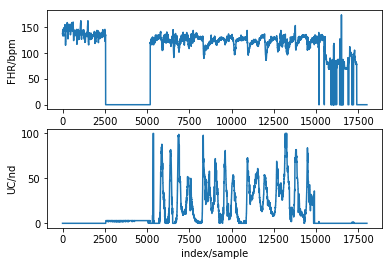

In [6]:
#Use wfdb library to plot records
exampleRecordName = str(FHRprocData['record'].iloc[0])

exampleRecord = wfdb.rdsamp(path + '/' + exampleRecordName, sampfrom=0, sampto=None, channels=None,
                     physical=True, pbdir = None, m2s=True)


#Use wfdb library to plot record
wfdb.plotrec(exampleRecord)

# Histograms of input features:

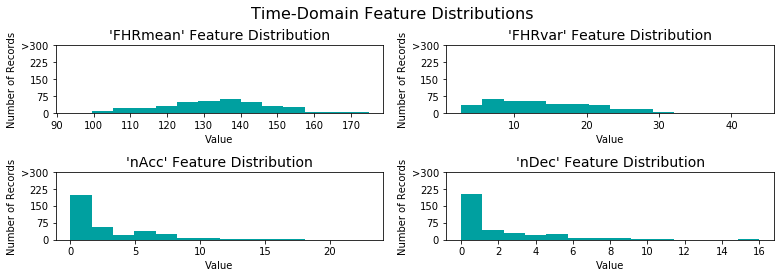

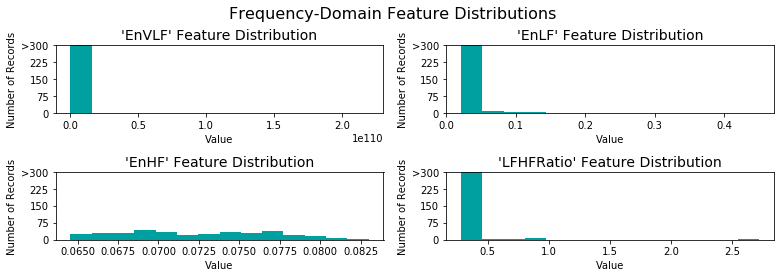

In [7]:
# #of bins by Rice's Rule
bins = round((len(FHRprocData)**(1/3))*2)
featureNamesTime=['FHRmean','FHRvar','nAcc','nDec']
TitleTime="Time-Domain Feature Distributions"
vs.histPlot(FHRprocData,featureNamesTime,TitleTime,bins)

featureNamesFreq=['EnVLF','EnLF','EnHF','LFHFRatio']
TitleFreq="Frequency-Domain Feature Distributions"
vs.histPlot(FHRprocData,featureNamesFreq,TitleFreq,bins)


Log Transform all of the features to attempt to help skewed distributions

In [8]:
#Create a Raw Features dataframe with out extra columns.
Xraw = FHRprocData.drop(['pH','delType','record','StageLabel'],axis=1)

#Create a Raw DataFrame of just the Stage Labels
Y = pd.DataFrame(FHRprocData['StageLabel'],columns=['StageLabel'])
#Log transform features included in skewed list, shift by 1 to not have log(0) error
#I will transform all features since scaling will occur anyway next 
skewed = ['FHRmean','FHRvar','nAcc','nDec','EnVLF','EnLF','EnHF','LFHFRatio']
XlogTran=Xraw[skewed].copy().apply(lambda x: np.log(x + 1))

## Scaling Data

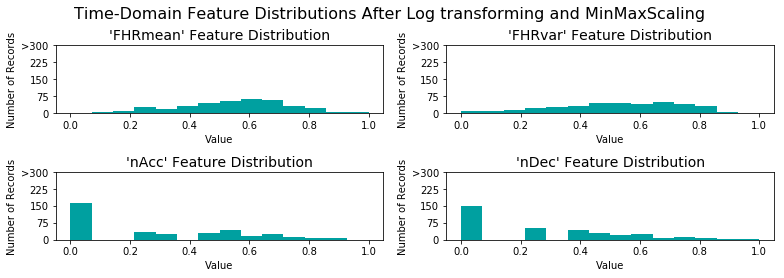

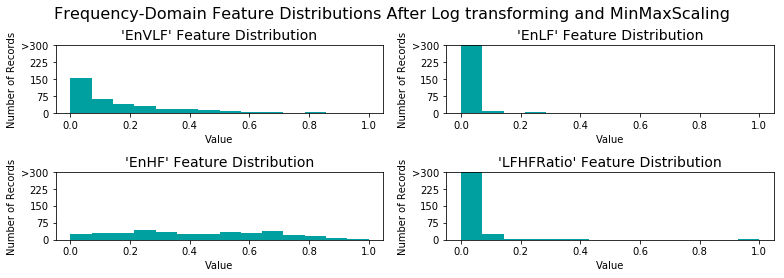

In [9]:
#Initialize MinMaxScaler
scaler = MinMaxScaler()
#Fit and Transform Data
scaledData = scaler.fit_transform(XlogTran.copy(deep=True))
#Create dataframe with scaled features
Xscaled=pd.DataFrame(scaledData)
featureNames=list(XlogTran.columns.values)
Xscaled.columns=featureNames

#Visualize features - scaling should not change distributions
# #of bins by Rice's Rule
bins = round((len(FHRprocData)**(1/3))*2)
TitleTime="Time-Domain Feature Distributions After Log transforming and MinMaxScaling "
vs.histPlot(Xscaled,featureNamesTime,TitleTime,bins)

TitleFreq="Frequency-Domain Feature Distributions After Log transforming and MinMaxScaling"
vs.histPlot(Xscaled,featureNamesFreq,TitleFreq,bins)

## Boxplot of Scaled Features

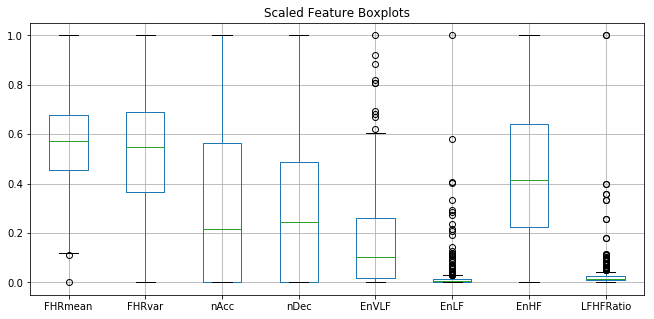

In [10]:
#Boxplot of scaled feature
fig = plt.figure(figsize = (11,5));
ax_boxplot=Xscaled.boxplot(column=featureNames)
ax_boxplot.set_title("Scaled Feature Boxplots")
fig.show()

## Outlier Removal

In [11]:
#Create dataframes which will have outliers remoed based on +/- 1.5*IQR
good_data = Xscaled.copy()
Ygood=Y.copy()
#Loop through each feature
for feature in Xscaled.keys():
    
    #Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(Xscaled[feature],25.0)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(Xscaled[feature],75.0)
    
    #Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    # Display the outliers
    print("Q1 for {} is {}".format(feature,Q1))
    print("Q3 for {} is {}:".format(feature,Q3))
    #Remove outliers
    Ygood=Ygood[((good_data[feature] >= Q1 - step) & (good_data[feature] <= Q3 + step))]
    good_data=good_data[((good_data[feature] >= Q1 - step) & (good_data[feature] <= Q3 + step))]
    # Display the outliers
    print("Data points considered outliers for the feature {}:".format(feature))
    display(Xscaled[~((Xscaled[feature] >= Q1 - step) & (Xscaled[feature] <= Q3 + step))])
    display(len(Xscaled[~((Xscaled[feature] >= Q1 - step) & (Xscaled[feature] <= Q3 + step))]))

Q1 for FHRmean is 0.45349960001176526
Q3 for FHRmean is 0.6795593745223201:
Data points considered outliers for the feature FHRmean:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
195,0.112114,0.704898,0.218104,0.568061,0.071687,0.191936,0.133112,0.006401
302,0.000000,0.657892,0.000000,0.632412,0.537740,0.008552,0.205623,0.010649


2

Q1 for FHRvar is 0.3669734116417037
Q3 for FHRvar is 0.6884413673454812:
Data points considered outliers for the feature FHRvar:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio


0

Q1 for nAcc is 0.0
Q3 for nAcc is 0.5637914160289368:
Data points considered outliers for the feature nAcc:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio


0

Q1 for nDec is 0.0
Q3 for nDec is 0.489301084236452:
Data points considered outliers for the feature nDec:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio


0

Q1 for EnVLF is 0.019380637415542763
Q3 for EnVLF is 0.2590098059042889:
Data points considered outliers for the feature EnVLF:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
28,0.488013,0.162606,0.000000,0.000000,0.694773,0.003198,0.779157,0.002288
42,0.299055,0.390412,0.000000,0.000000,0.817789,0.003950,0.748094,0.006326
162,0.947895,0.560213,0.436209,0.000000,0.680956,0.010080,0.347836,0.049867
196,0.946718,0.482115,0.436209,0.000000,0.806569,0.008386,0.334591,0.015540
198,0.335099,0.535290,0.000000,0.000000,0.808299,0.005861,0.341054,0.010625
199,0.280030,0.644894,0.000000,0.000000,0.882579,0.004011,0.389722,0.014360
211,0.907769,0.343363,0.000000,0.000000,0.670070,0.003146,0.532494,0.009909
332,0.161797,0.661958,0.000000,0.489301,0.622773,0.013724,0.155883,0.048772
337,0.826425,0.096498,0.000000,0.000000,1.000000,0.013858,0.995232,0.110110
338,0.786115,0.529992,0.436209,0.000000,0.919048,0.006329,0.791328,0.020057


10

Q1 for EnLF is 0.0034560416215883467
Q3 for EnLF is 0.013884890094505806:
Data points considered outliers for the feature EnLF:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
3,0.672142,0.673020,0.000000,0.244651,0.000451,0.064684,0.043993,0.256810
4,0.521834,0.718864,0.218104,0.387762,0.005452,0.042130,0.090401,0.179511
19,0.767507,0.755719,0.654313,0.387762,0.109896,0.097853,0.010825,0.359769
36,0.447160,0.704699,0.000000,0.489301,0.007049,0.113888,0.073114,0.396633
45,0.374410,0.773491,0.000000,0.632412,0.039846,0.402350,0.013523,1.000000
75,0.648430,0.729383,0.000000,0.489301,0.002074,0.091010,0.058409,0.334314
184,0.222513,0.932576,0.506422,0.632412,0.059219,0.333973,0.038184,0.088230
185,0.591160,0.682428,0.345687,0.387762,0.015669,0.039706,0.178740,0.256810
186,0.482133,0.815685,0.345687,0.632412,0.049837,0.107783,0.103829,0.179511
195,0.112114,0.704898,0.218104,0.568061,0.071687,0.191936,0.133112,0.006401


49

Q1 for EnHF is 0.22288126691126187
Q3 for EnHF is 0.6416608244943556:
Data points considered outliers for the feature EnHF:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio


0

Q1 for LFHFRatio is 0.010601124067531192
Q3 for LFHFRatio is 0.02553608783888453:
Data points considered outliers for the feature LFHFRatio:


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
1,0.499249,0.537677,0.000000,0.000000,0.000051,0.010335,0.219134,0.059162
2,0.590478,0.596413,0.218104,0.244651,0.000192,0.018217,0.205198,0.088230
3,0.672142,0.673020,0.000000,0.244651,0.000451,0.064684,0.043993,0.256810
4,0.521834,0.718864,0.218104,0.387762,0.005452,0.042130,0.090401,0.179511
5,0.131833,0.636175,0.000000,0.387762,0.009242,0.013966,0.231832,0.071300
15,0.536475,0.806702,0.436209,0.489301,0.122436,0.023327,0.240908,0.103360
19,0.767507,0.755719,0.654313,0.387762,0.109896,0.097853,0.010825,0.359769
20,0.489537,0.614020,0.218104,0.244651,0.035262,0.015026,0.199411,0.077344
32,0.926772,0.681165,0.506422,0.000000,0.548456,0.012571,0.263186,0.064202
36,0.447160,0.704699,0.000000,0.489301,0.007049,0.113888,0.073114,0.396633


60

In [12]:
#Reset Indexes on dataframes after outlier removal
good_data.reset_index(drop=True, inplace=True)
Ygood.reset_index(drop=True, inplace=True)
#List Number of samples of each class after outlier removal
print("Number of Stage 1 samples after outlier detection {}".format(len(Ygood[Ygood['StageLabel']==1])))
print("Number of Stage 2 samples after outlier detection {}".format(len(Ygood[Ygood['StageLabel']==2])))

Number of Stage 1 samples after outlier detection 150
Number of Stage 2 samples after outlier detection 117


In [13]:
#Statistics of outlier removed dataset
good_data.describe()

,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,0.571604,0.467029,0.270620,0.270678,0.149686,0.006190,0.514665,0.014746
std,0.170803,0.197285,0.301702,0.281483,0.158355,0.005531,0.212609,0.006959
min,0.117633,0.000000,0.000000,0.000000,0.000000,0.000000,0.014113,0.000000
25%,0.484289,0.327750,0.000000,0.000000,0.015662,0.002990,0.341598,0.010253
50%,0.586499,0.474372,0.218104,0.244651,0.101084,0.004168,0.539591,0.013692
75%,0.684037,0.613605,0.563791,0.489301,0.224312,0.006650,0.673057,0.017520
max,1.000000,0.927919,1.000000,1.000000,0.605886,0.028870,1.000000,0.042555


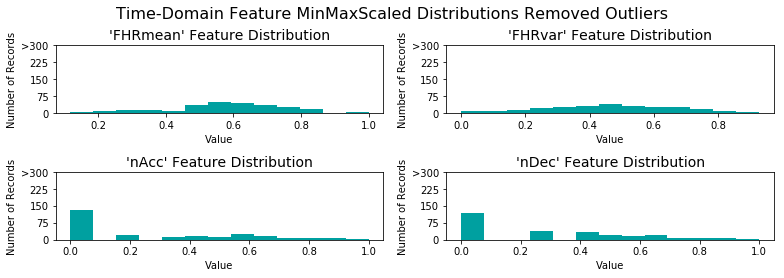

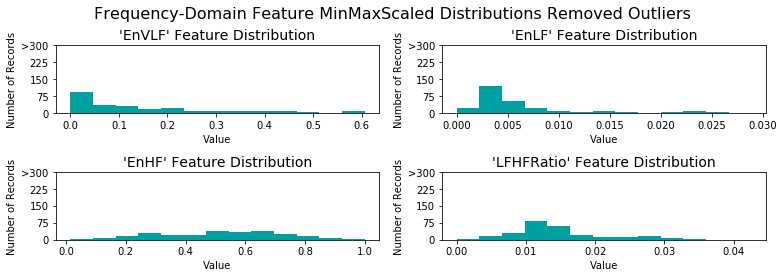

In [14]:
#histograms of features with removed outliers
# #of bins by Rice's Rule
bins = round((len(good_data)**(1/3))*2)
TitleTime="Time-Domain Feature MinMaxScaled Distributions Removed Outliers"
vs.histPlot(good_data,featureNamesTime,TitleTime,bins)

TitleFreq="Frequency-Domain Feature MinMaxScaled Distributions Removed Outliers"
vs.histPlot(good_data,featureNamesFreq,TitleFreq,bins)

## Covariance Matricies

A covariance matrix is visualized in order to observe interactions between features.

Data with Outliers

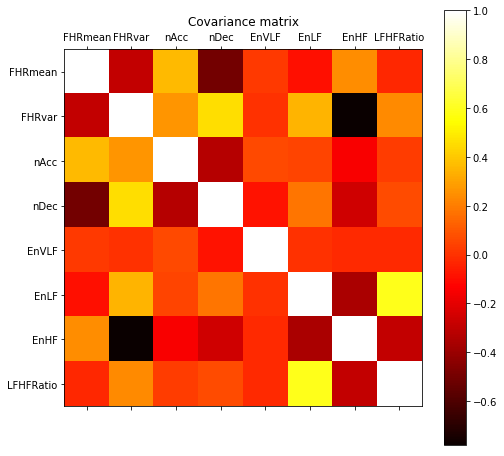

In [15]:
#Create Figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#plot covariance matrix of scaled dataframe
cax = ax.matshow(Xscaled.corr(),cmap='hot')
plt.title("Covariance matrix")
#Show colorbar
fig.colorbar(cax)
#Set tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([''] + featureNames)
ax.set_yticklabels([''] + featureNames)
plt.tight_layout
#Show the plot
plt.show()

Data without outliers

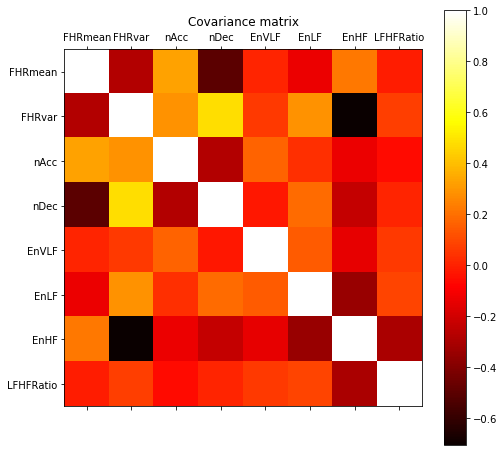

In [16]:
#Create Figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#plot covariance matrix of good_data dataframe
cax = ax.matshow(good_data.corr(),cmap='hot')
plt.title("Covariance matrix")
#Show colorbar
fig.colorbar(cax)
#Set tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([''] + featureNames)
ax.set_yticklabels([''] + featureNames)
plt.tight_layout
#Show the plot
plt.show()

## PCA Decomposition

Since some features tend to covary PCA may help us reduce dimmensionality.

PCA on data with outliers

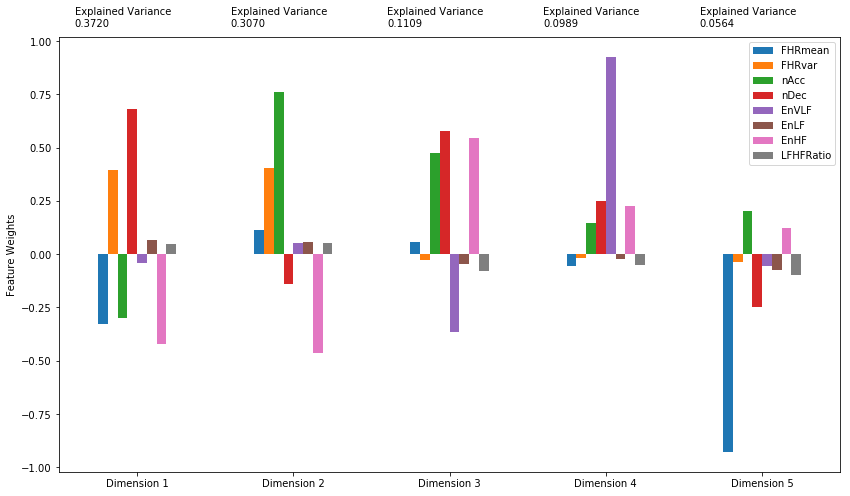

In [17]:
#Initialize PCA Object with 5 components
pca = PCA(n_components = 5)
#Fit to the raw scaled Data
pca.fit(Xscaled)
XPCA=pca.transform(Xscaled)
# Generate PCA results plot
pca_results = vs.pca_results(Xscaled, pca)
XPCA = pd.DataFrame(XPCA, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3','Dimension 4','Dimension 5'])

In [18]:
#Explained Variance of the 5 components
expvar_ratios=pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
#Find various sums of the explained variance ratios for the 1st thru 5th component
expvar_one=expvar_ratios[0]
expvar_two=np.sum(expvar_ratios[0:2])
expvar_three=np.sum(expvar_ratios[0:3])
expvar_four=np.sum(expvar_ratios[0:4])
expvar_five=np.sum(expvar_ratios[0:5])
print("Explained Variance of the first PCA component is: ",expvar_one)
print("Explained Variance of the first 2 PCA components is: ",expvar_two)
print("Explained Variance of the first 3 PCA components is: ",expvar_three)
print("Explained Variance of the first 4 PCA components is: ",expvar_four)
print("Explained Variance of the first 5 PCA components is: ",expvar_five)

Explained Variance of the first PCA component is:  [ 0.37202891]
Explained Variance of the first 2 PCA components is:  0.679013506561
Explained Variance of the first 3 PCA components is:  0.789900477342
Explained Variance of the first 4 PCA components is:  0.888772129283
Explained Variance of the first 5 PCA components is:  0.945215181554


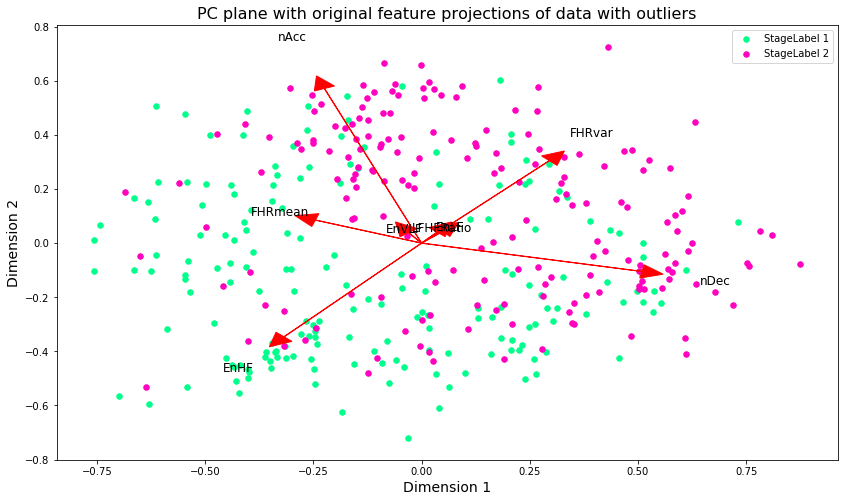

In [19]:
#Reduced Dimmension DataFrame
XPCARed2d=XPCA[['Dimension 1','Dimension 2']].copy()
vs.biplot(Xscaled,XPCARed2d,Y,pca,"PC plane with original feature projections of data with outliers")

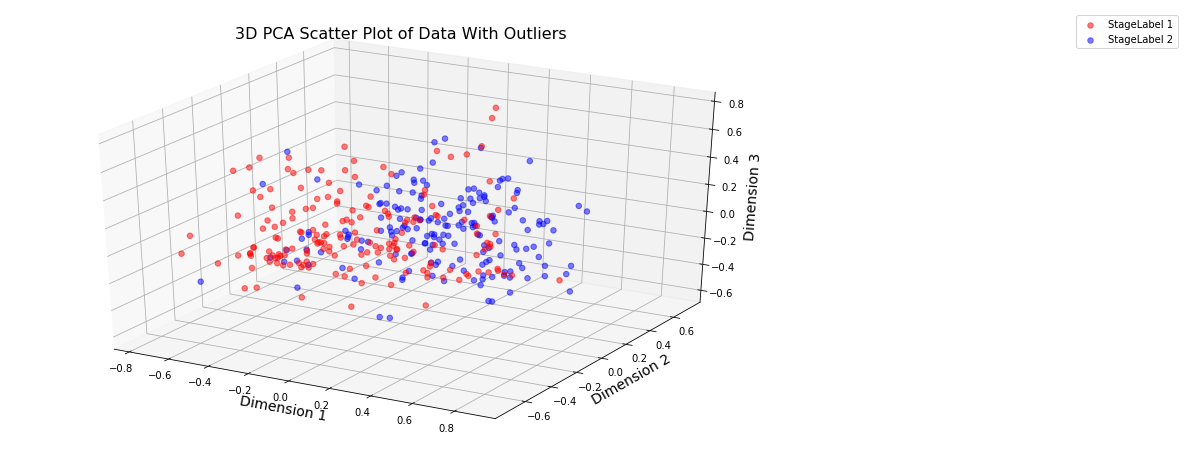

In [20]:
#Plot 3D scatterplot of reduced pca features with outliers
XPCARed3d=XPCA[['Dimension 1','Dimension 2','Dimension 3']].copy()
vs.biplot3D(XPCARed3d,Y,'3D PCA Scatter Plot of Data With Outliers')

PCa on data without outliers

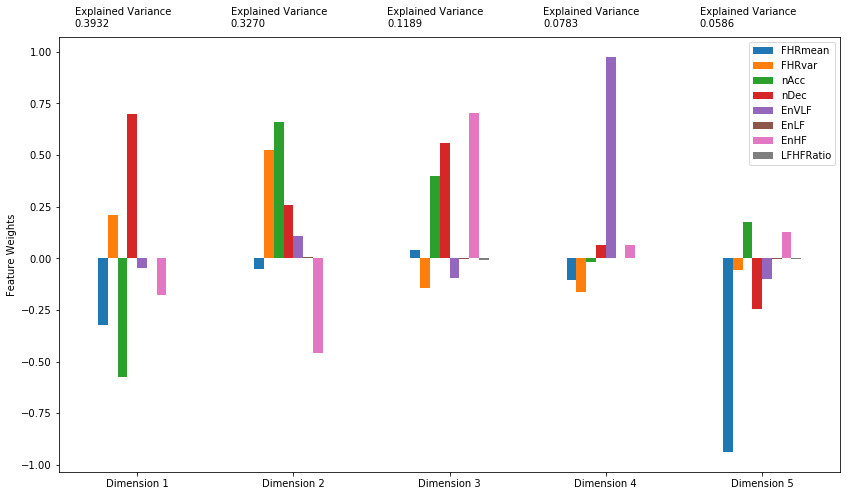

In [21]:
#Initialize PCA Object with 5 components
pca = PCA(n_components = 5)
#Fit to the scaled Data
pca.fit(good_data)
XPCAgood_data=pca.transform(good_data)
# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)


In [22]:
#Explained Variance of the 5 components
expvar_ratios=pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
#Find various sums of the explained variance ratios for the 1st thru 5th component
expvar_one=expvar_ratios[0]
expvar_two=np.sum(expvar_ratios[0:2])
expvar_three=np.sum(expvar_ratios[0:3])
expvar_four=np.sum(expvar_ratios[0:4])
expvar_five=np.sum(expvar_ratios[0:5])
print("Explained Variance of the first PCA component is: ",expvar_one)
print("Explained Variance of the first 2 PCA components is: ",expvar_two)
print("Explained Variance of the first 3 PCA components is: ",expvar_three)
print("Explained Variance of the first 4 PCA components is: ",expvar_four)
print("Explained Variance of the first 5 PCA components is: ",expvar_five)

Explained Variance of the first PCA component is:  [ 0.39317741]
Explained Variance of the first 2 PCA components is:  0.720154163237
Explained Variance of the first 3 PCA components is:  0.839064693477
Explained Variance of the first 4 PCA components is:  0.917362580257
Explained Variance of the first 5 PCA components is:  0.975931179895


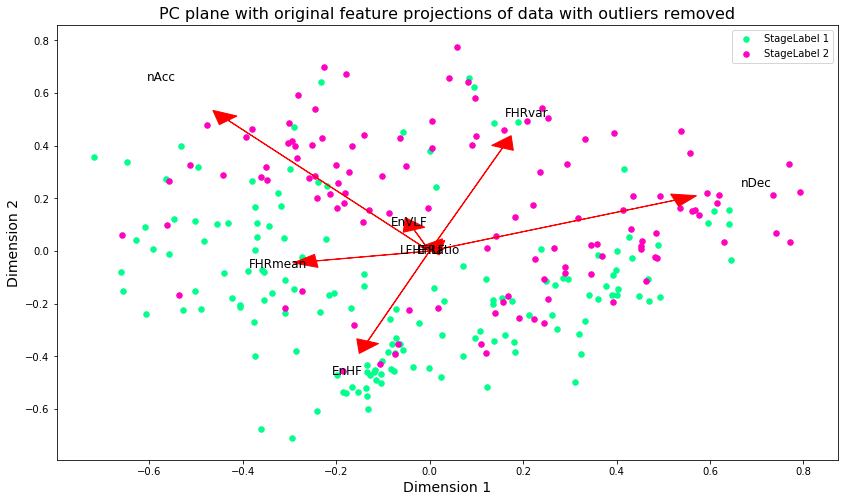

In [23]:
#Initialize PCA Object with 3 components
pca = PCA(n_components = 3)
#Fit to the scaled Data
pca.fit(good_data)
XPCAgood_data=pca.transform(good_data)
XPCAgood_data = pd.DataFrame(XPCAgood_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
#Reduced Dimmension DataFrame
XPCAgood_dataRed2d=XPCAgood_data[['Dimension 1','Dimension 2']].copy()
vs.biplot(good_data,XPCAgood_dataRed2d,Ygood,pca,"PC plane with original feature projections of data with outliers removed")

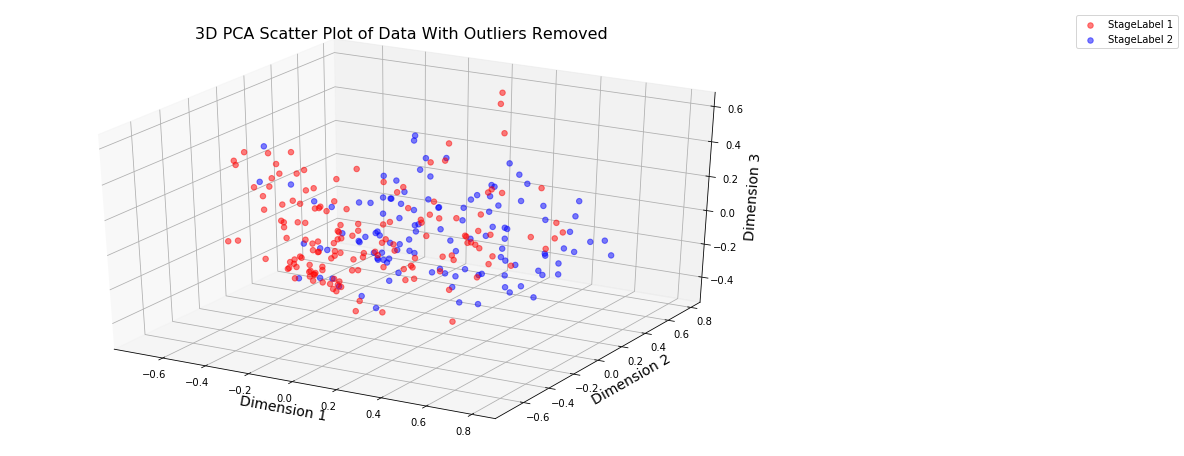

In [24]:
#Plot 3d scatterplot of pca features on data without outliers
XPCAgood_dataRed3d=XPCAgood_data[['Dimension 1','Dimension 2','Dimension 3']].copy()
vs.biplot3D(XPCAgood_dataRed3d,Ygood,'3D PCA Scatter Plot of Data With Outliers Removed')

# Isomap Decomposition

## Isomap 2D Scatter Plot

Isomap reconstruction error with 2 components is 0.17726983227513485


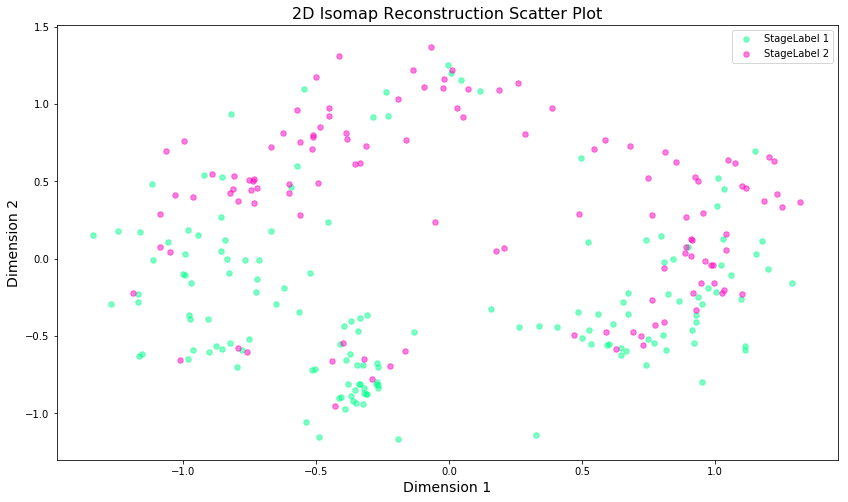

In [25]:
#Create an isomap object
isomap=Isomap(n_components=2)
Xiso_pred=isomap.fit_transform(good_data)
print("Isomap reconstruction error with 2 components is {}".format(isomap.reconstruction_error()))
#Plot 2 component isomap projection
XISORed2d = pd.DataFrame(Xiso_pred, columns = ['Dimension 1', 'Dimension 2'])
vs.isomap2D(XISORed2d,Ygood,"2D Isomap Reconstruction Scatter Plot")

0.1439107648480302

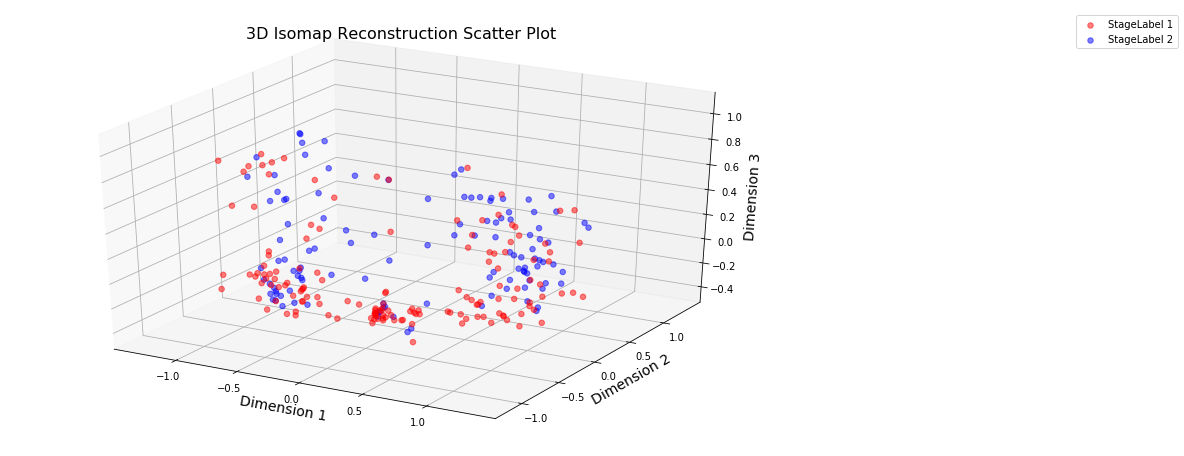

In [26]:
#Plot 3D isomap scatterplot
isomap=Isomap(n_components=3)
Xiso_pred=isomap.fit_transform(good_data)
display(isomap.reconstruction_error())
XISORed3d = pd.DataFrame(Xiso_pred, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
vs.biplot3D(XISORed3d,Ygood,"3D Isomap Reconstruction Scatter Plot")


# Unsupervised Exploration

## Benchmark K means

In [27]:
#Copy 3D PCA Reduction for kmeans model
XkmeansBench = XPCAgood_dataRed3d.copy()
#Fit kmeans Model
kmeans = KMeans(n_clusters=2, n_init = 100, random_state=0).fit(XkmeansBench)
#Get Cluster Labels (Starting from 0)
YkmeansBench = kmeans.labels_
#Put Cluster labels into a dummy coded dataframe with XkmeansBench 
EncodedkmeansBench = pd.get_dummies(YkmeansBench,prefix='Cluster')
XkmeansBenchWithClusters = pd.concat([XkmeansBench, EncodedkmeansBench], axis = 1)
XkmeansBenchWithClusters.reset_index(drop=True,inplace=True)

#Display Descriptive Stats of Cluster 1
print("Cluster 0 (1 of 2) Statistics")
display(XkmeansBenchWithClusters[XkmeansBenchWithClusters['Cluster_0']==1].describe())
display(good_data[XkmeansBenchWithClusters['Cluster_0']==1].describe())

#Display Descriptive Stats of Cluster 2
print("Cluster 1 (2 of 2) Statistics")
display(XkmeansBenchWithClusters[XkmeansBenchWithClusters['Cluster_1']==1].describe())
display(good_data[XkmeansBenchWithClusters['Cluster_1']==1].describe())

Cluster 0 (1 of 2) Statistics


,Dimension 1,Dimension 2,Dimension 3,Cluster_0,Cluster_1
count,150.000000,150.000000,150.000000,150.0,150.0
mean,0.215183,-0.160277,-0.018056,1.0,0.0
std,0.269204,0.255325,0.177476,0.0,0.0
min,-0.360857,-0.711266,-0.475490,1.0,0.0
25%,-0.054179,-0.371711,-0.131587,1.0,0.0
50%,0.237478,-0.175973,-0.034344,1.0,0.0
75%,0.415478,0.021909,0.103094,1.0,0.0
max,0.792143,0.455537,0.503303,1.0,0.0


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.506247,0.431466,0.034540,0.368265,0.116378,0.006102,0.536928,0.014925
std,0.173858,0.189341,0.092455,0.285977,0.156624,0.005507,0.205184,0.006822
min,0.117633,0.000000,0.000000,0.000000,0.000000,0.000000,0.032116,0.000000
25%,0.374133,0.287202,0.000000,0.000000,0.001100,0.003071,0.379987,0.010311
50%,0.533245,0.438563,0.000000,0.387762,0.048062,0.004133,0.551145,0.013763
75%,0.616039,0.553503,0.000000,0.568061,0.142152,0.006360,0.681194,0.017903
max,1.000000,0.881351,0.436209,1.000000,0.605886,0.028870,1.000000,0.032944


Cluster 1 (2 of 2) Statistics


,Dimension 1,Dimension 2,Dimension 3,Cluster_0,Cluster_1
count,117.000000,117.000000,117.000000,117.0,117.0
mean,-0.275875,0.205484,0.023149,0.0,1.0
std,0.220465,0.268189,0.206776,0.0,0.0
min,-0.718754,-0.397337,-0.404591,0.0,1.0
25%,-0.406618,0.005781,-0.129859,0.0,1.0
50%,-0.293429,0.245741,0.029917,0.0,1.0
75%,-0.171717,0.409312,0.160733,0.0,1.0
max,0.252329,0.774243,0.600861,0.0,1.0


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.655395,0.512623,0.573287,0.145566,0.192389,0.006303,0.486122,0.014517
std,0.124368,0.198670,0.182431,0.220313,0.150728,0.005583,0.219351,0.007153
min,0.256056,0.023089,0.218104,0.000000,0.000168,0.000683,0.014113,0.000000
25%,0.571292,0.362717,0.436209,0.000000,0.064882,0.002936,0.300889,0.010239
50%,0.663031,0.527016,0.563791,0.000000,0.180845,0.004246,0.490029,0.012732
75%,0.750802,0.669121,0.691374,0.244651,0.265303,0.007255,0.641454,0.017218
max,0.933891,0.927919,1.000000,0.846352,0.605018,0.028386,0.974135,0.042555


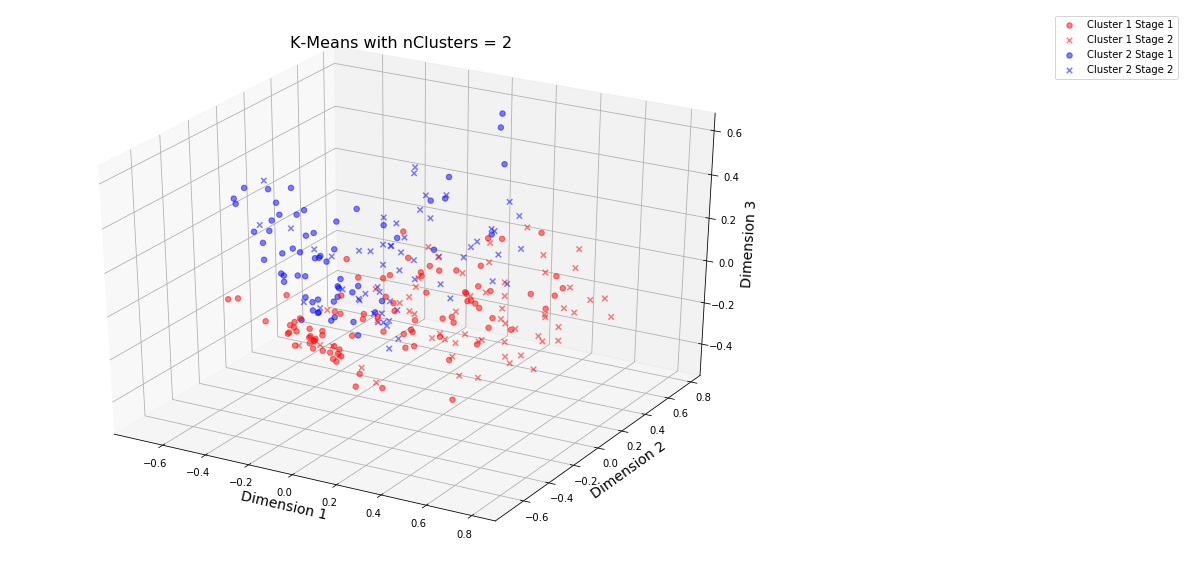

In [28]:
#Put Cluster label array into a dataframe
YkmeansBenchDF=pd.DataFrame(YkmeansBench+1,columns=['Cluster'])
#Visualize on 3d scatterplot
vs.clustplot3D(XkmeansBench, Ygood, YkmeansBenchDF,"K-Means with nClusters = 2")

Benchmark Evaluation Statistics

In [29]:
#Convert StageLabels to array form
Ygoodarray = np.array(Ygood['StageLabel'])
#Calculate Evaluation characteristics
silScore = silhouette_score(XkmeansBench,YkmeansBench)
ariScore = adjusted_rand_score(Ygoodarray,YkmeansBench)
homScore = homogeneity_score(Ygoodarray,YkmeansBench)
anmiScore = adjusted_mutual_info_score(Ygoodarray,YkmeansBench)
purityScore = purity_score(Ygoodarray-1,YkmeansBench)
#Print out characteristics
print("Silhouette Score is {}".format(silScore))
print("ARI Score is {}".format(ariScore))
print("Homogeneity Score is {}".format(homScore))
print("ANMI Score is {}".format(anmiScore))
print("Purity Score is {}".format(purityScore))

Silhouette Score is 0.3487565191366792
ARI Score is 0.0035555193898270466
Homogeneity Score is 0.003775675542678391
ANMI Score is 0.0010305420366738748
Purity Score is 0.5617977528089888


## K-Means Pipeline

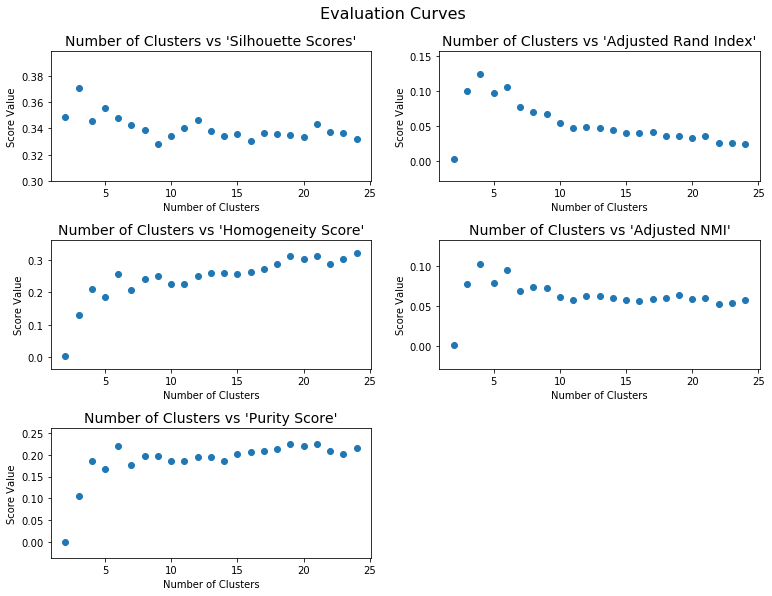

In [30]:
#Initialize arrays of evaluation metrics
silScores = []
ariScores = []
homScores = []
anmiScores = []
purityScores = []

#Copy feature array
XkmeansPipeline = XPCAgood_dataRed3d.copy()

#Look at models between 2 and 25 clusters
for nclust in range(2,25):

    kmeans = KMeans(n_clusters=nclust, n_init = 15, random_state=0).fit(XkmeansPipeline)
    YkmeansPipeline = kmeans.labels_
    silScores.append(silhouette_score(XkmeansPipeline,YkmeansPipeline))
    ariScores.append(adjusted_rand_score(Ygoodarray,YkmeansPipeline))
    homScores.append(homogeneity_score(Ygoodarray,YkmeansPipeline))
    anmiScores.append(adjusted_mutual_info_score(Ygoodarray,YkmeansPipeline))
    purityScores.append(purity_score(Ygoodarray-1,YkmeansPipeline)-0.562)
    
#create dataframe of scores
kmeansScoresDF=pd.DataFrame({'Silhouette Scores': silScores,'Adjusted Rand Index': ariScores,'Homogeneity Score': homScores,
                            'Adjusted NMI':anmiScores,'Purity Score':purityScores})
#score names
scoreNames=['Silhouette Scores','Adjusted Rand Index', 'Homogeneity Score', 'Adjusted NMI', 'Purity Score']
#Create plots of curves for each evaluation metric
fig = plt.figure(figsize = (11,8));
#Create array for range of clusters evaluated
clusterVector = list(range(2,25))
#feature plotting
for i, feature in enumerate(scoreNames):
    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(clusterVector,kmeansScoresDF[feature])
    ax.set_title("Number of Clusters vs '%s'"%(feature), fontsize = 14)
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score Value")
    #ax.set_ylim((0, 200))
    #ax.set_yticks([0, 75, 150, 225, 300])
    #ax.set_yticklabels([0, 75, 150, 225, ">300"])

# Plot aesthetics
fig.suptitle("Evaluation Curves", \
    fontsize = 16, y = 1.03)
fig.tight_layout() 
fig.show()

## Optimal K-means Model 

In [31]:
#Run kmeans with optimal number of clusters chosen
XkmeansOpt = XPCAgood_dataRed3d.copy()
kmeans = KMeans(n_clusters=4, n_init = 100, random_state=0).fit(XkmeansOpt)
YkmeansOpt = kmeans.labels_

EncodedkmeansOpt = pd.get_dummies(YkmeansOpt,prefix='Cluster')
XkmeansOptWithClusters = pd.concat([XkmeansOpt, EncodedkmeansOpt], axis = 1)
XkmeansOptWithClusters.reset_index(drop=True,inplace=True)

#Display Descriptive Stats of Stage 1
print("Cluster 0 (1 of 4) Statistics")
display(XkmeansOptWithClusters[XkmeansOptWithClusters['Cluster_0']==1].describe())
display(good_data[XkmeansOptWithClusters['Cluster_0']==1].describe())

print("Cluster 1 (2 of 4) Statistics")
display(XkmeansOptWithClusters[XkmeansOptWithClusters['Cluster_1']==1].describe())
display(good_data[XkmeansOptWithClusters['Cluster_1']==1].describe())

print("Cluster 2 (3 of 4) Statistics")
display(XkmeansOptWithClusters[XkmeansOptWithClusters['Cluster_2']==1].describe())
display(good_data[XkmeansOptWithClusters['Cluster_2']==1].describe())

print("Cluster 3 (4 of 4) Statistics")
display(XkmeansOptWithClusters[XkmeansOptWithClusters['Cluster_3']==1].describe())
display(good_data[XkmeansOptWithClusters['Cluster_3']==1].describe())

#Import model evaluation libraries
silScore = silhouette_score(XkmeansOpt,YkmeansOpt)
ariScore = adjusted_rand_score(Ygoodarray,YkmeansOpt)
homScore = homogeneity_score(Ygoodarray,YkmeansOpt)
anmiScore = adjusted_mutual_info_score(Ygoodarray,YkmeansOpt)
purityScore = purity_score(Ygoodarray-1,YkmeansOpt)

print("Silhouette Score is {}".format(silScore))
print("ARI Score is {}".format(ariScore))
print("Homogeneity Score is {}".format(homScore))
print("ANMI Score is {}".format(anmiScore))
print("Purity Score is {}".format(purityScore))


#Get Centers

centers = kmeans.cluster_centers_
display(centers)


Cluster 0 (1 of 4) Statistics


,Dimension 1,Dimension 2,Dimension 3,Cluster_0,Cluster_1,Cluster_2,Cluster_3
count,46.000000,46.000000,46.000000,46.0,46.0,46.0,46.0
mean,-0.453118,-0.032575,0.088399,1.0,0.0,0.0,0.0
std,0.127898,0.170085,0.157066,0.0,0.0,0.0,0.0
min,-0.718754,-0.397337,-0.173837,1.0,0.0,0.0,0.0
25%,-0.558087,-0.165757,-0.048259,1.0,0.0,0.0,0.0
50%,-0.426750,-0.047627,0.065038,1.0,0.0,0.0,0.0
75%,-0.356304,0.094326,0.203034,1.0,0.0,0.0,0.0
max,-0.221470,0.355884,0.381477,1.0,0.0,0.0,0.0


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.715554,0.315661,0.546547,0.005318,0.236778,0.004598,0.668322,0.012825
std,0.108734,0.127693,0.198656,0.036072,0.143373,0.002402,0.156566,0.006092
min,0.477586,0.023089,0.218104,0.000000,0.000294,0.000683,0.309004,0.003340
25%,0.657861,0.234627,0.345687,0.000000,0.174054,0.002958,0.544642,0.009991
50%,0.705873,0.334398,0.563791,0.000000,0.215712,0.004163,0.661597,0.011229
75%,0.790123,0.405875,0.706973,0.000000,0.295016,0.006229,0.804669,0.015107
max,0.933891,0.533570,1.000000,0.244651,0.605018,0.011763,0.974135,0.032944


Cluster 1 (2 of 4) Statistics


,Dimension 1,Dimension 2,Dimension 3,Cluster_0,Cluster_1,Cluster_2,Cluster_3
count,79.000000,79.000000,79.000000,79.0,79.0,79.0,79.0
mean,-0.013350,-0.353627,-0.027017,0.0,1.0,0.0,0.0
std,0.161612,0.141565,0.164079,0.0,0.0,0.0,0.0
min,-0.360857,-0.711266,-0.392157,0.0,1.0,0.0,0.0
25%,-0.134089,-0.458573,-0.130656,0.0,1.0,0.0,0.0
50%,-0.066642,-0.354455,-0.043926,0.0,1.0,0.0,0.0
75%,0.128871,-0.239959,0.059314,0.0,1.0,0.0,0.0
max,0.324561,-0.056603,0.503303,0.0,1.0,0.0,0.0


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,0.608041,0.300211,0.030369,0.151918,0.067120,0.004846,0.659502,0.013940
std,0.126123,0.130650,0.075990,0.197884,0.136081,0.002514,0.142757,0.005897
min,0.311480,0.000000,0.000000,0.000000,0.000000,0.000767,0.272183,0.000000
25%,0.524716,0.213732,0.000000,0.000000,0.000062,0.003137,0.563135,0.010195
50%,0.611082,0.298835,0.000000,0.000000,0.006129,0.004231,0.670171,0.013408
75%,0.682385,0.381674,0.000000,0.244651,0.059165,0.006056,0.740937,0.016069
max,1.000000,0.651299,0.218104,0.686821,0.583082,0.013793,1.000000,0.032422


Cluster 2 (3 of 4) Statistics


,Dimension 1,Dimension 2,Dimension 3,Cluster_0,Cluster_1,Cluster_2,Cluster_3
count,67.000000,67.000000,67.000000,67.0,67.0,67.0,67.0
mean,-0.158807,0.390824,-0.013257,0.0,0.0,1.0,0.0
std,0.195005,0.154948,0.229136,0.0,0.0,0.0,0.0
min,-0.532877,0.111509,-0.404591,0.0,0.0,1.0,0.0
25%,-0.291432,0.272826,-0.199775,0.0,0.0,1.0,0.0
50%,-0.197532,0.399207,0.013469,0.0,0.0,1.0,0.0
75%,0.002891,0.487121,0.117572,0.0,0.0,1.0,0.0
max,0.252329,0.774243,0.600861,0.0,0.0,1.0,0.0


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.613843,0.652526,0.612851,0.250547,0.171059,0.007675,0.356259,0.015809
std,0.121152,0.104628,0.147831,0.241330,0.149928,0.006794,0.162916,0.007757
min,0.256056,0.437756,0.345687,0.000000,0.006603,0.001847,0.014113,0.000000
25%,0.549442,0.589829,0.506422,0.000000,0.054144,0.003180,0.246449,0.010353
50%,0.613962,0.660239,0.563791,0.244651,0.136601,0.004626,0.337544,0.014119
75%,0.692493,0.721468,0.691374,0.387762,0.229314,0.010199,0.488270,0.019890
max,0.843977,0.927919,0.926491,0.846352,0.592359,0.028386,0.705408,0.042555


Cluster 3 (4 of 4) Statistics


,Dimension 1,Dimension 2,Dimension 3,Cluster_0,Cluster_1,Cluster_2,Cluster_3
count,75.000000,75.000000,75.000000,75.0,75.0,75.0,75.0
mean,0.433842,0.043330,-0.013917,0.0,0.0,0.0,1.0
std,0.153275,0.168383,0.189090,0.0,0.0,0.0,0.0
min,0.122555,-0.267052,-0.475490,0.0,0.0,0.0,1.0
25%,0.332847,-0.095927,-0.161471,0.0,0.0,0.0,1.0
50%,0.416114,0.023317,-0.031264,0.0,0.0,0.0,1.0
75%,0.536104,0.156654,0.128626,0.0,0.0,0.0,1.0
max,0.792143,0.455537,0.402419,0.0,0.0,0.0,1.0


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.407200,0.569874,0.048724,0.576510,0.164147,0.007257,0.409368,0.015825
std,0.156563,0.128101,0.112800,0.191849,0.159540,0.007209,0.177194,0.007483
min,0.117633,0.288101,0.000000,0.244651,0.000027,0.000000,0.032116,0.003537
25%,0.268148,0.481004,0.000000,0.387762,0.037099,0.002913,0.278845,0.010547
50%,0.395060,0.552104,0.000000,0.568061,0.110362,0.004016,0.389736,0.013763
75%,0.542240,0.638990,0.000000,0.710386,0.303943,0.007085,0.541860,0.018713
max,0.805420,0.881351,0.436209,1.000000,0.605886,0.028870,0.760695,0.032944


Silhouette Score is 0.3455668601540266
ARI Score is 0.12481505791543605
Homogeneity Score is 0.21213252802122293
ANMI Score is 0.10265611730865856
Purity Score is 0.7490636704119851


array([[-0.45311832, -0.03257495,  0.08839908],
       [-0.01335022, -0.35362724, -0.02701693],
       [-0.1588071 ,  0.39082439, -0.0132573 ],
       [ 0.43384248,  0.04333021, -0.01391708]])

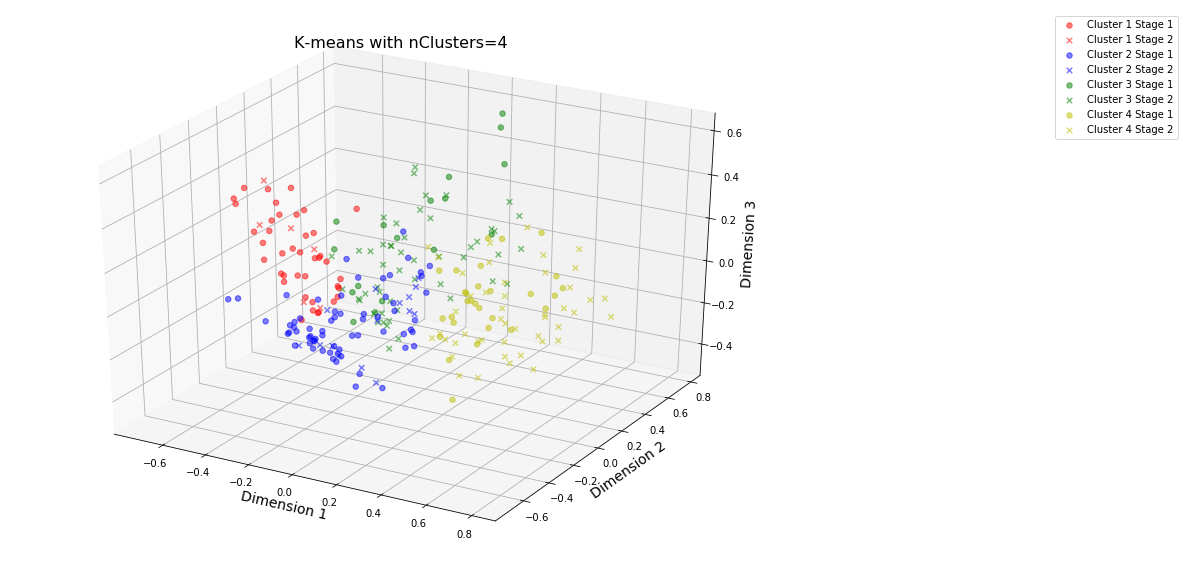

In [32]:
#Visualize Clustering in 3d Scatterplot
YkmeansOptDF=pd.DataFrame(YkmeansOpt+1,columns=['Cluster'])
vs.clustplot3D(XPCAgood_dataRed3d, Ygood, YkmeansOptDF,"K-means with nClusters=4")

In [33]:
#Get Cluster breakup by Labor Stage

#Initialize arrays
nInClusterList = []
nStage1List = []
nStage2List = []
percStage1List = []
percStage2List = []
index = []
#Loop Through each cluster a
for cluster in np.unique(YkmeansOptDF['Cluster']):
    nInCluster= len(YkmeansOptDF[YkmeansOptDF['Cluster']==cluster])
    #Get # of samples in cluster from stage 1 ane 2 and relative percentages
    nStage1=len(Ygood[(YkmeansOptDF['Cluster']==cluster) & (Ygood['StageLabel']==1)])
    nStage2=len(Ygood[(YkmeansOptDF['Cluster']==cluster) & (Ygood['StageLabel']==2)])
    percStage1=nStage1/nInCluster
    percStage2=nStage2/nInCluster
    #Append to list
    nInClusterList.append(nInCluster)
    nStage1List.append(nStage1)
    nStage2List.append(nStage2)
    percStage1List.append(percStage1)
    percStage2List.append(percStage2)
    
    index.append("Cluster {}".format(cluster))
    
    
#Put results in a dataframe
YkmeansOptclusterMakeupDF=pd.DataFrame({'nInCluster': nInClusterList,'nStage1':nStage1List,'nStage2':nStage2List,
                      'percStage1':percStage1List,'percStage2':percStage2List},
                            index=index)
#display the dataframe
display(YkmeansOptclusterMakeupDF)

#Get Centers

centers = kmeans.cluster_centers_
scaled_centers = pca.inverse_transform(centers)
log_centers = scaler.inverse_transform(scaled_centers)
true_centers = np.exp(log_centers)-1
# Display the true centers
segments = ['Cluster Center{}'.format(i+1) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = featureNames)
true_centers.index = segments
display(true_centers)

,nInCluster,nStage1,nStage2,percStage1,percStage2
Cluster 1,46,40,6,0.869565,0.130435
Cluster 2,79,64,15,0.810127,0.189873
Cluster 3,67,17,50,0.253731,0.746269
Cluster 4,75,29,46,0.386667,0.613333


,FHRmean,FHRvar,nAcc,nDec,EnVLF,EnLF,EnHF,LFHFRatio
Cluster Center1,147.0,8.0,5.0,-0.0,2.554175e+17,0.0,0.0,0.0
Cluster Center2,136.0,6.0,0.0,1.0,4.571110e+12,0.0,0.0,0.0
Cluster Center3,137.0,17.0,6.0,1.0,1.231999e+22,0.0,0.0,0.0
Cluster Center4,122.0,15.0,0.0,4.0,1.151971e+15,0.0,0.0,0.0


## Hierarchical Model

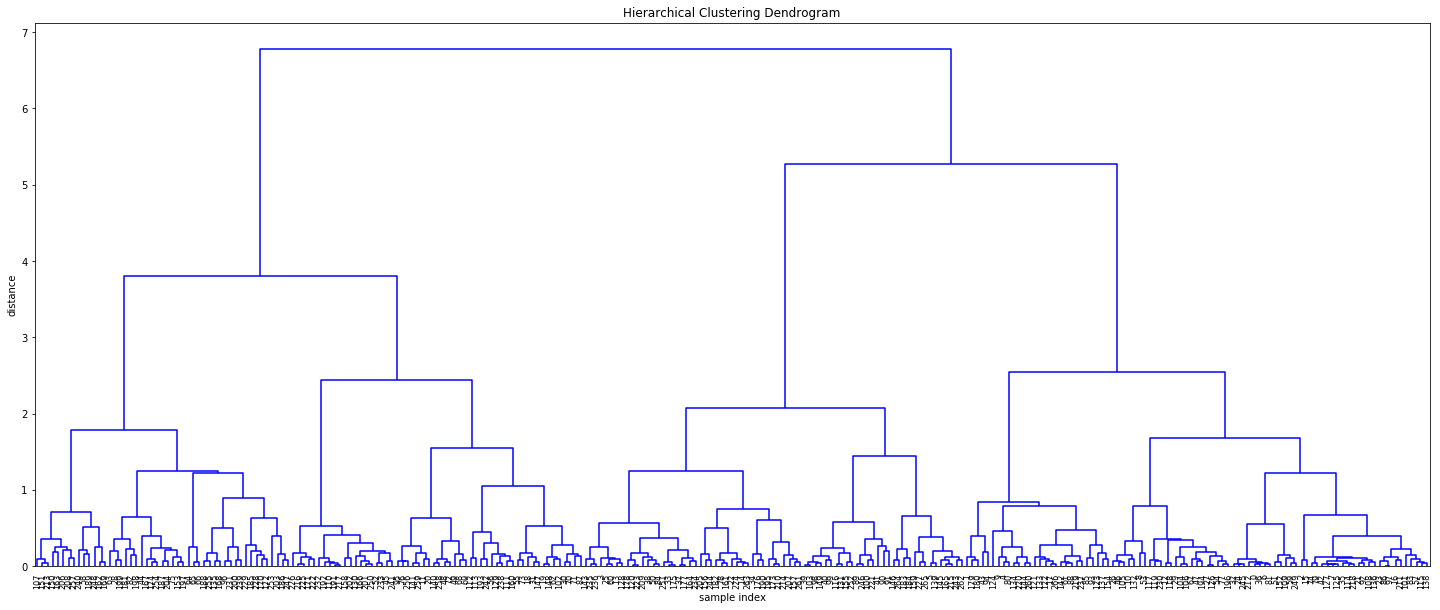

In [34]:
XscaledHier = XPCAgood_dataRed3d.copy()
# calculate full dendrogram
HierModel = linkage(XscaledHier,'ward')
#plot Dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendogramDict=dendrogram(
    HierModel,
    truncate_mode='lastp',  # show only the last p merged clusters: set to number of samples
    p=len(XscaledHier),
    color_threshold=0,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

## Benchmark Hierarchical Model

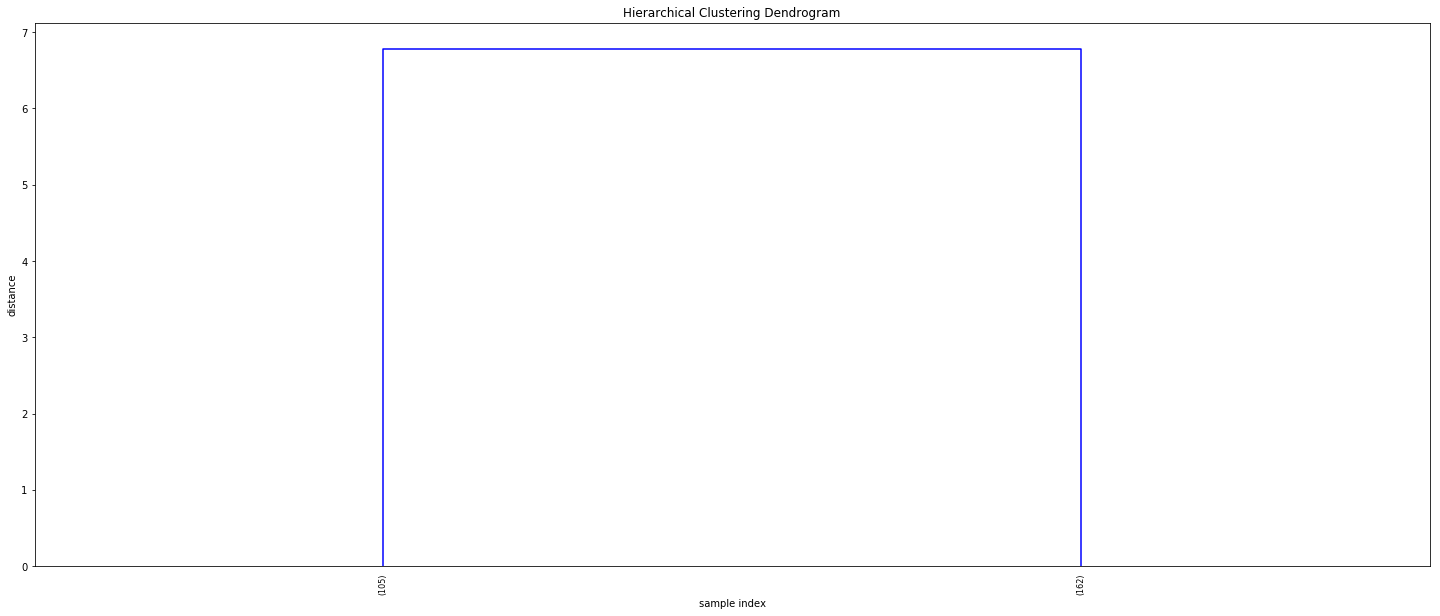

In [35]:
XscaledHierBench = XPCAgood_dataRed3d.copy()
# calculate  dendrogram 
HierModelBench = linkage(XscaledHierBench,'ward')
#Plot last 2 clusters
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendogramDict=dendrogram(
    HierModelBench,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=2,
    color_threshold=0,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
## Get cluster Labels starting from 1
clusterLabelsBench = fcluster(HierModelBench,2,criterion='maxclust')

#Calculate model evaluation metrics
silScore = silhouette_score(XscaledHierBench,clusterLabelsBench)
ariScore = adjusted_rand_score(Ygoodarray,clusterLabelsBench)
homScore = homogeneity_score(Ygoodarray,clusterLabelsBench)
anmiScore = adjusted_mutual_info_score(Ygoodarray,clusterLabelsBench)
purityScore = purity_score(Ygoodarray-1,clusterLabelsBench)
#Print evaluation metrics
print("Silhouette Score is {}".format(silScore))
print("ARI Score is {}".format(ariScore))
print("Homogeneity Score is {}".format(homScore))
print("ANMI Score is {}".format(anmiScore))
print("Purity Score is {}".format(purityScore))

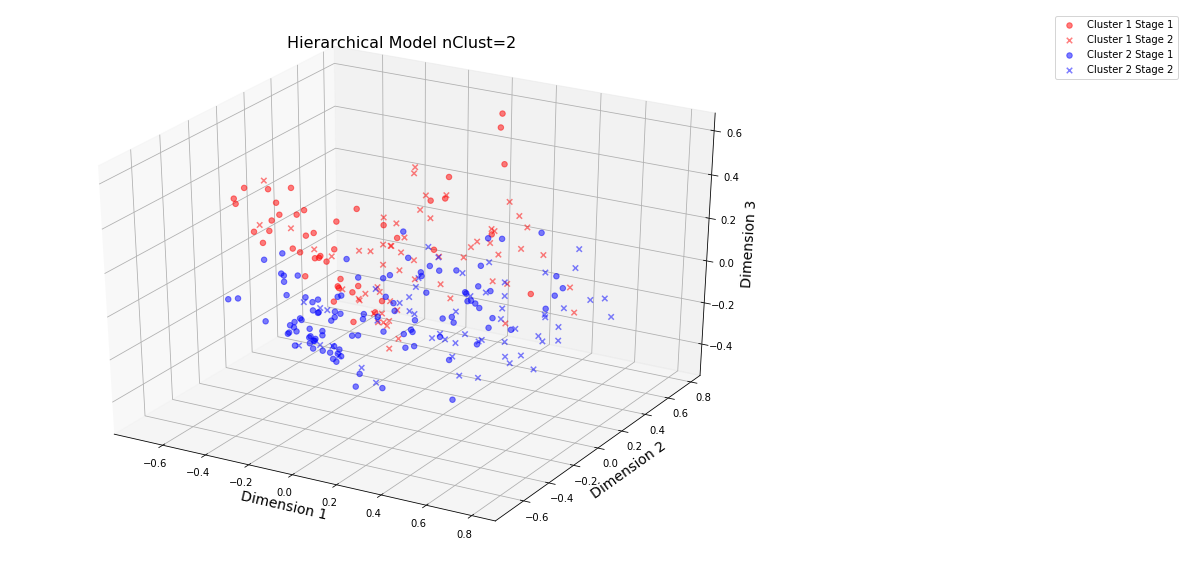

In [37]:
#Put Cluster labels into DF
clusterLabelsBenchDF=pd.DataFrame(clusterLabelsBench,columns=['Cluster'])
#Visualize Clusters
vs.clustplot3D(XscaledHierBench, Ygood, clusterLabelsBenchDF,"Hierarchical Model nClust=2")

## Hierarchical Model Pipeline

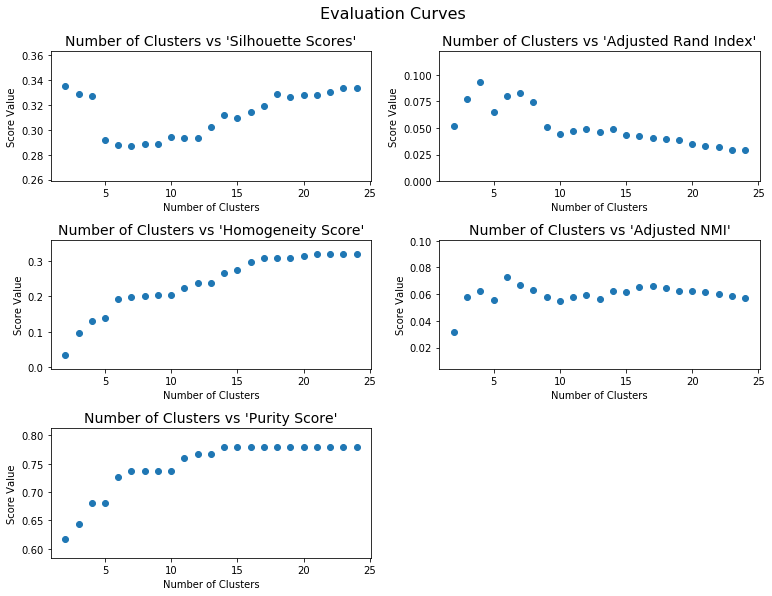

In [38]:
#Initialize Arrays
silScores = []
ariScores = []
homScores = []
anmiScores = []
purityScores = []
XscaledHierPipeline = XPCAgood_dataRed3d.copy()
#Calculate Dendogram
HierModelPipeline = linkage(XscaledHierPipeline,'ward')
#loop through models with 2-25 clusters
for nclust in range(2,25):
    #Get Labels for nclust
    clusterLabelsPipeline = fcluster(HierModelPipeline,nclust,criterion='maxclust')
    #Calculate Evaluation Metrics
    silScores.append(silhouette_score(XscaledHierPipeline,clusterLabelsPipeline))
    ariScores.append(adjusted_rand_score(Ygoodarray,clusterLabelsPipeline))
    homScores.append(homogeneity_score(Ygoodarray,clusterLabelsPipeline))
    anmiScores.append(adjusted_mutual_info_score(Ygoodarray,clusterLabelsPipeline))
    purityScores.append(purity_score(Ygoodarray-1,clusterLabelsPipeline))

#Put Scores into dataframe
HierScoresDF=pd.DataFrame({'Silhouette Scores': silScores,'Adjusted Rand Index': ariScores,'Homogeneity Score': homScores,
                            'Adjusted NMI':anmiScores,'Purity Score':purityScores})
#score names
scoreNames=['Silhouette Scores','Adjusted Rand Index', 'Homogeneity Score', 'Adjusted NMI', 'Purity Score']
fig = plt.figure(figsize = (11,8));
clusterVector = list(range(2,25))
#feature plotting
for i, feature in enumerate(scoreNames):
    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(clusterVector,HierScoresDF[feature])
    ax.set_title("Number of Clusters vs '%s'"%(feature), fontsize = 14)
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score Value")
    #ax.set_ylim((0, 200))
    #ax.set_yticks([0, 75, 150, 225, 300])
    #ax.set_yticklabels([0, 75, 150, 225, ">300"])

# Plot aesthetics
fig.suptitle("Evaluation Curves", \
    fontsize = 16, y = 1.03)
fig.tight_layout() 
fig.show()

## Optimal Hierarchicak Model

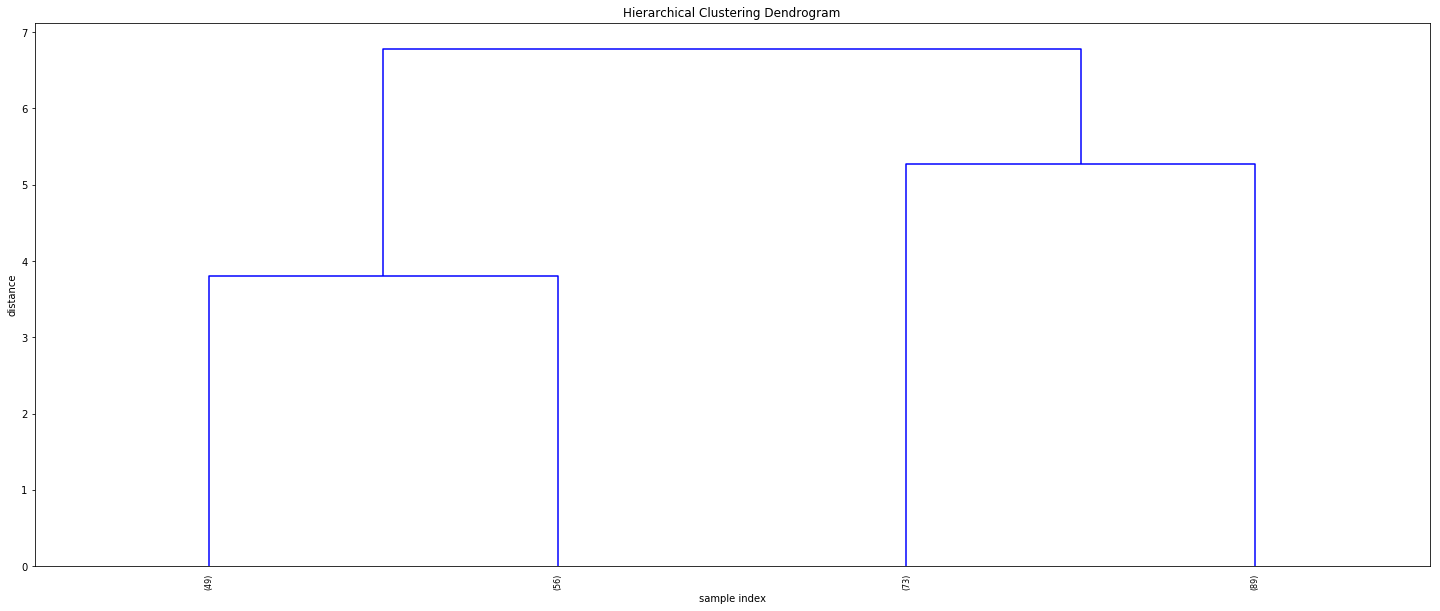

Silhouette Score is 0.32698694839198045
ARI Score is 0.0929115079102783
Homogeneity Score is 0.13202052954378066
ANMI Score is 0.06265458324106428
Purity Score is 0.6816479400749064


In [39]:
XscaledHierOpt = XPCAgood_dataRed3d.copy()
#Calculate Dendogram
HierModelOpt = linkage(XscaledHierOpt,'ward')
#Get cluster lables for 4 clusters
clusterLabelsOpt = fcluster(HierModelOpt,4,criterion='maxclust')

#Plot Dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendogramDict=dendrogram(
    HierModelOpt,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=4,
    color_threshold=0,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#Get Evaluation Metrics
silScore = silhouette_score(XscaledHierOpt,clusterLabelsOpt)
ariScore = adjusted_rand_score(Ygoodarray,clusterLabelsOpt)
homScore = homogeneity_score(Ygoodarray,clusterLabelsOpt)
anmiScore = adjusted_mutual_info_score(Ygoodarray,clusterLabelsOpt)
purityScore = purity_score(Ygoodarray-1,clusterLabelsOpt)
#Print Metrics
print("Silhouette Score is {}".format(silScore))
print("ARI Score is {}".format(ariScore))
print("Homogeneity Score is {}".format(homScore))
print("ANMI Score is {}".format(anmiScore))
print("Purity Score is {}".format(purityScore))

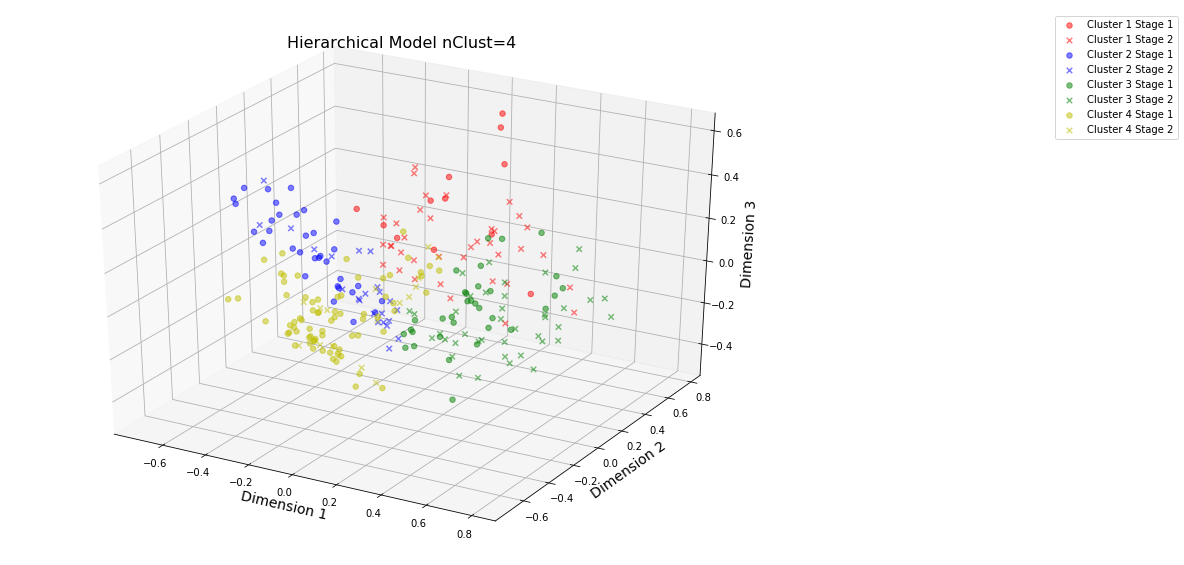

In [40]:
#Put Cluster labels into DF
clusterLabelsOptDF=pd.DataFrame(clusterLabelsOpt,columns=['Cluster'])
#Visualize Clusters
vs.clustplot3D(XscaledHierOpt, Ygood, clusterLabelsOptDF,"Hierarchical Model nClust=4")

In [41]:
#Get Information of Cluster Makeup by Labor Stage
#Initialize arrays
nInClusterList = []
nStage1List = []
nStage2List = []
percStage1List = []
percStage2List = []
index = []
#Loop through each cluster and get makeup by labor stage
for cluster in np.unique(clusterLabelsOptDF['Cluster']):
    nInCluster= len(clusterLabelsOptDF[clusterLabelsOptDF['Cluster']==cluster])
    nStage1=len(Ygood[(clusterLabelsOptDF['Cluster']==cluster) & (Ygood['StageLabel']==1)])
    nStage2=len(Ygood[(clusterLabelsOptDF['Cluster']==cluster) & (Ygood['StageLabel']==2)])
    percStage1=nStage1/nInCluster
    percStage2=nStage2/nInCluster
    
    nInClusterList.append(nInCluster)
    nStage1List.append(nStage1)
    nStage2List.append(nStage2)
    percStage1List.append(percStage1)
    percStage2List.append(percStage2)
    
    index.append("Cluster {}".format(cluster))
    print("Cluster {} has {} members with {} Stage 1 Samples and {} Stage 2 Samples".format(cluster,nInCluster, nStage1, nStage2))
#Put results in dataframe and display\\\\\\\\\\\\\\\\\\\\\
HierOptclusterMakeupDF=pd.DataFrame({'nInCluster': nInClusterList,'nStage1':nStage1List,'nStage2':nStage2List,
                      'percStage1':percStage1List,'percStage2':percStage2List},
                            index=index)

display(HierOptclusterMakeupDF)

Cluster 1 has 49 members with 12 Stage 1 Samples and 37 Stage 2 Samples
Cluster 2 has 56 members with 33 Stage 1 Samples and 23 Stage 2 Samples
Cluster 3 has 73 members with 33 Stage 1 Samples and 40 Stage 2 Samples
Cluster 4 has 89 members with 72 Stage 1 Samples and 17 Stage 2 Samples


,nInCluster,nStage1,nStage2,percStage1,percStage2
Cluster 1,49,12,37,0.244898,0.755102
Cluster 2,56,33,23,0.589286,0.410714
Cluster 3,73,33,40,0.452055,0.547945
Cluster 4,89,72,17,0.808989,0.191011


## Supervised Learning

## Decision Tree

In [42]:
#Copy features for supervised learning
XSup= XPCAgood_dataRed3d.copy()
accRecordsRed3dDecTree=[]
gridObjsDecTree = []
for i in range(1,11):

    #Create a training set for use during gridsearch and a testing set for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(XSup, Ygoodarray, 
                                                        test_size = 0.25, random_state = (i+(15*i)),shuffle=True)

    # set of parameters to tune
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [2, 3, 4],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [2,3, 4, 5, 6]}

    #create dectree object
    DecTree = DecisionTreeClassifier(random_state=0)
    #Set kf parameters
    kf=KFold(n_splits=4,shuffle=True,random_state=0)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_objDecTree = GridSearchCV(DecTree,param_grid,cv=kf)

    #Fit the grid search object to the training data and find the optimal parameters
    grid_fitDecTree = grid_objDecTree.fit(X_train, y_train)

    #Results on Testing Data

    #Calculate Accuracy
    acc=grid_fitDecTree.best_estimator_.score(X_test,y_test)
    #Save best fit to obj lest
    gridObjsDecTree.append(grid_fitDecTree.best_estimator_)
    #Get predictions and calculate confusion matrix
    ytree_pred = grid_fitDecTree.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,ytree_pred).ravel()
    
    #Display average accuracy score
    print("Accuracy on Testing Set: {}".format(acc))
    #save accuracy in accuracy list
    accRecordsRed3dDecTree.append(acc)
    #Calculate percision, recall, and f1score
    percision = tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(percision*recall)/(percision+recall)
    print("TP is {}, TN is: {}, FP is {}, FN is {}".format(tp,tn,fp,fn))
    print("Percision is {}, Recall is {}, and F1-Score is {}".format(percision,recall,f1))

Accuracy on Testing Set: 0.7611940298507462
TP is 18, TN is: 33, FP is 4, FN is 12
Percision is 0.8181818181818182, Recall is 0.6, and F1-Score is 0.34615384615384615
Accuracy on Testing Set: 0.7611940298507462
TP is 27, TN is: 24, FP is 13, FN is 3
Percision is 0.675, Recall is 0.9, and F1-Score is 0.3857142857142857
Accuracy on Testing Set: 0.6417910447761194
TP is 17, TN is: 26, FP is 15, FN is 9
Percision is 0.53125, Recall is 0.6538461538461539, and F1-Score is 0.2931034482758621
Accuracy on Testing Set: 0.7014925373134329
TP is 14, TN is: 33, FP is 9, FN is 11
Percision is 0.6086956521739131, Recall is 0.56, and F1-Score is 0.2916666666666667
Accuracy on Testing Set: 0.7761194029850746
TP is 18, TN is: 34, FP is 7, FN is 8
Percision is 0.72, Recall is 0.6923076923076923, and F1-Score is 0.35294117647058826
Accuracy on Testing Set: 0.7761194029850746
TP is 26, TN is: 26, FP is 6, FN is 9
Percision is 0.8125, Recall is 0.7428571428571429, and F1-Score is 0.3880597014925374
Accuracy

In [43]:
#Display descriptive statistics on accuracy
accRecordsRed3dDecTreeDF = pd.DataFrame(accRecordsRed3dDecTree)
display(accRecordsRed3dDecTreeDF.describe())
display(gridObjsDecTree)

,0
count,10.000000
mean,0.729851
std,0.052393
min,0.641791
25%,0.701493
50%,0.746269
75%,0.772388
max,0.791045


[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='bes

In [46]:
accRecordsRedClustDecTree= []
gridObjsDecTreeClust = []
for i in range(1,11):
    XSup= XPCAgood_dataRed3d.copy()

    #Create a training set for use during gridsearch and a testing set for final evaluation
    X_trainOrig, X_testOrig, y_train, y_test = train_test_split(XSup, Ygoodarray, 
                                                        test_size = 0.25, random_state = (i+(15*i)),shuffle=True)

    #Run kmeans with optimal number of clusters chosen
    XkmeansOptSup = X_trainOrig.copy()
    kmeans = KMeans(n_clusters=4, n_init = 100, random_state=0).fit(XkmeansOptSup)
    YkmeansOptSup = kmeans.labels_

    EncodedkmeansOptSup = pd.get_dummies(YkmeansOptSup,prefix='Cluster')
   
    #Copy features for supervised learning
    X_train= EncodedkmeansOptSup.copy()
    
    X_test = pd.get_dummies(kmeans.predict(X_testOrig))
    # set of parameters to tune
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [2, 3, 4],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [2,3, 4, 5, 6]}

    #Create dectree obj
    DecTree = DecisionTreeClassifier(random_state=0)
    #set k fold parameters
    kf=KFold(n_splits=4,shuffle=True,random_state=0)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_objDecTree = GridSearchCV(DecTree,param_grid,cv=kf)

    #Fit the grid search object to the training data and find the optimal parameters
    grid_fitDecTree = grid_objDecTree.fit(X_train, y_train)
    #Save best fit
    gridObjsDecTreeClust.append(grid_fitDecTree.best_estimator_)

    #Results on Testing Data

    #Calculate Accuracy
    acc=grid_fitDecTree.best_estimator_.score(X_test,y_test)
    #Get predictions and calculate confusion matrix
    ytree_pred = grid_fitDecTree.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,ytree_pred).ravel()

    #Display average accuracy score
    print("Accuracy on Testing Set: {}".format(acc))
    #Save acc
    accRecordsRedClustDecTree.append(acc)
    
    #Calculate percision, recall, and f1score
    percision = tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(percision*recall)/(percision+recall)
    print("TP is {}, TN is: {}, FP is {}, FN is {}".format(tp,tn,fp,fn))
    print("Percision is {}, Recall is {}, and F1-Score is {}".format(percision,recall,f1))

Accuracy on Testing Set: 0.7164179104477612
TP is 17, TN is: 31, FP is 6, FN is 13
Percision is 0.7391304347826086, Recall is 0.5666666666666667, and F1-Score is 0.32075471698113206
Accuracy on Testing Set: 0.746268656716418
TP is 26, TN is: 24, FP is 13, FN is 4
Percision is 0.6666666666666666, Recall is 0.8666666666666667, and F1-Score is 0.37681159420289856
Accuracy on Testing Set: 0.7611940298507462
TP is 21, TN is: 30, FP is 11, FN is 5
Percision is 0.65625, Recall is 0.8076923076923077, and F1-Score is 0.36206896551724144
Accuracy on Testing Set: 0.6417910447761194
TP is 14, TN is: 29, FP is 13, FN is 11
Percision is 0.5185185185185185, Recall is 0.56, and F1-Score is 0.2692307692307692
Accuracy on Testing Set: 0.7910447761194029
TP is 23, TN is: 30, FP is 11, FN is 3
Percision is 0.6764705882352942, Recall is 0.8846153846153846, and F1-Score is 0.3833333333333333
Accuracy on Testing Set: 0.7611940298507462
TP is 27, TN is: 24, FP is 8, FN is 8
Percision is 0.7714285714285715, Re

In [48]:
#Display descriptive statistics on accuracy
accRecordsRedClusDecTreetDF = pd.DataFrame(accRecordsRedClustDecTree)
display(accRecordsRedClusDecTreetDF.describe())
display(gridObjsDecTreeClust)

,0
count,10.000000
mean,0.726866
std,0.048771
min,0.641791
25%,0.694030
50%,0.731343
75%,0.761194
max,0.791045


[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=3, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=3, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='bes

# Random Forest

In [44]:
#Copy features for supervised learning
XSup= XPCAgood_dataRed3d.copy()
accRecordsRed3dForest = []
gridObjsForest = []

for i in range(1,11):

    #Create a training set for use during gridsearch and a testing set for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(XSup, Ygoodarray, 
                                                        test_size = 0.25, random_state = (i+(15*i)),shuffle=True)

    #create forest obj
    forest = RandomForestClassifier(n_estimators=10,random_state=0)
    # set of parameters to test
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [2, 3, 4],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [2,3, 4, 5, 6],
                  }

    #Set K-fold parameters
    kf=KFold(n_splits=4,shuffle=True,random_state=0)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_objForest = GridSearchCV(forest,param_grid,cv=kf)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fitForest = grid_objForest.fit(X_train, y_train)

    #Results on Testing Data

    #Calculate Accuracy
    acc=grid_fitForest.best_estimator_.score(X_test,y_test)
    #Get predictions and calculate confusion matrix
    ytree_pred = grid_fitForest.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,ytree_pred).ravel()
    #save best fit
    gridObjsForest.append(grid_fitForest.best_estimator_)

    #Display average accuracy score
    print("Accuracy on Testing Set: {}".format(acc))
    #save acc
    accRecordsRed3dForest.append(acc)
    #Calculate percision, recall, and f1score
    percision = tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(percision*recall)/(percision+recall)
    print("TP is {}, TN is: {}, FP is {}, FN is {}".format(tp,tn,fp,fn))
    print("Percision is {}, Recall is {}, and F1-Score is {}".format(percision,recall,f1))

    

Accuracy on Testing Set: 0.7761194029850746
TP is 20, TN is: 32, FP is 5, FN is 10
Percision is 0.8, Recall is 0.6666666666666666, and F1-Score is 0.3636363636363636
Accuracy on Testing Set: 0.7313432835820896
TP is 17, TN is: 32, FP is 5, FN is 13
Percision is 0.7727272727272727, Recall is 0.5666666666666667, and F1-Score is 0.3269230769230769
Accuracy on Testing Set: 0.6417910447761194
TP is 17, TN is: 26, FP is 15, FN is 9
Percision is 0.53125, Recall is 0.6538461538461539, and F1-Score is 0.2931034482758621
Accuracy on Testing Set: 0.7164179104477612
TP is 14, TN is: 34, FP is 8, FN is 11
Percision is 0.6363636363636364, Recall is 0.56, and F1-Score is 0.29787234042553196
Accuracy on Testing Set: 0.7910447761194029
TP is 18, TN is: 35, FP is 6, FN is 8
Percision is 0.75, Recall is 0.6923076923076923, and F1-Score is 0.35999999999999993
Accuracy on Testing Set: 0.746268656716418
TP is 24, TN is: 26, FP is 6, FN is 11
Percision is 0.8, Recall is 0.6857142857142857, and F1-Score is 0.

In [45]:
#Display descriptive statistics on accuracy
accRecordsRed3ForestDF = pd.DataFrame(accRecordsRed3dForest)
display(accRecordsRed3ForestDF.describe())
display(gridObjsForest)

,0
count,10.000000
mean,0.728358
std,0.042682
min,0.641791
25%,0.716418
50%,0.731343
75%,0.746269
max,0.791045


[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=2, max_features='auto', max_leaf_nodes=5,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=3,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=2,
             min_impurity_decrease=0.0,

In [49]:
#Copy features for supervised learning
accRecordsRed3dForestClust = []
gridObjsForestClust = []

for i in range(1,11):
    XSup= XPCAgood_dataRed3d.copy()
    #Create a training set for use during gridsearch and a testing set for final evaluation
    X_trainOrig, X_testOrig, y_train, y_test = train_test_split(XSup, Ygoodarray, 
                                                        test_size = 0.25, random_state = (i+(15*i)),shuffle=True)



    #Run kmeans with optimal number of clusters chosen
    XkmeansOptSup = X_trainOrig.copy()
    kmeans = KMeans(n_clusters=4, n_init = 100, random_state=0).fit(XkmeansOptSup)
    YkmeansOptSup = kmeans.labels_
    #Dummy code
    EncodedkmeansOptSup = pd.get_dummies(YkmeansOptSup,prefix='Cluster')
   
    #Copy features for supervised learning
    X_train= EncodedkmeansOptSup.copy()
    #Predict test set cluster labels
    X_test = pd.get_dummies(kmeans.predict(X_testOrig))
    #create forest obj
    forest = RandomForestClassifier(n_estimators=10,random_state=0)
    # set of parameters to test
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [2, 3, 4],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [2,3, 4, 5, 6],
                  }

    #Set K-fold parameters
    kf=KFold(n_splits=4,shuffle=True,random_state=0)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_objForest = GridSearchCV(forest,param_grid,cv=kf)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fitForest = grid_objForest.fit(X_train, y_train)

    #Results on Testing Data

    #Calculate Accuracy
    acc=grid_fitForest.best_estimator_.score(X_test,y_test)
    #Get predictions and calculate confusion matrix
    ytree_pred = grid_fitForest.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,ytree_pred).ravel()
    #save best fit
    gridObjsForestClust.append(grid_fitForest.best_estimator_)

    #Display average accuracy score
    print("Accuracy on Testing Set: {}".format(acc))
    #save acc
    accRecordsRed3dForestClust.append(acc)
    #Calculate percision, recall, and f1score
    percision = tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(percision*recall)/(percision+recall)
    print("TP is {}, TN is: {}, FP is {}, FN is {}".format(tp,tn,fp,fn))
    print("Percision is {}, Recall is {}, and F1-Score is {}".format(percision,recall,f1))

    

Accuracy on Testing Set: 0.7164179104477612
TP is 17, TN is: 31, FP is 6, FN is 13
Percision is 0.7391304347826086, Recall is 0.5666666666666667, and F1-Score is 0.32075471698113206
Accuracy on Testing Set: 0.746268656716418
TP is 26, TN is: 24, FP is 13, FN is 4
Percision is 0.6666666666666666, Recall is 0.8666666666666667, and F1-Score is 0.37681159420289856
Accuracy on Testing Set: 0.7611940298507462
TP is 21, TN is: 30, FP is 11, FN is 5
Percision is 0.65625, Recall is 0.8076923076923077, and F1-Score is 0.36206896551724144
Accuracy on Testing Set: 0.6417910447761194
TP is 14, TN is: 29, FP is 13, FN is 11
Percision is 0.5185185185185185, Recall is 0.56, and F1-Score is 0.2692307692307692
Accuracy on Testing Set: 0.7910447761194029
TP is 23, TN is: 30, FP is 11, FN is 3
Percision is 0.6764705882352942, Recall is 0.8846153846153846, and F1-Score is 0.3833333333333333
Accuracy on Testing Set: 0.7611940298507462
TP is 27, TN is: 24, FP is 8, FN is 8
Percision is 0.7714285714285715, Re

In [50]:
#Display descriptive statistics on accuracy
accRecordsRed3ForestClustDF = pd.DataFrame(accRecordsRed3dForestClust)
display(accRecordsRed3ForestClustDF.describe())
display(gridObjsForestClust)

,0
count,10.000000
mean,0.726866
std,0.048771
min,0.641791
25%,0.694030
50%,0.731343
75%,0.761194
max,0.791045


[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=4,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=3,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=3,
             min_impurity_decrease=0.0, min_

# Freeform Visualization

## Decision Tree Decision Tree

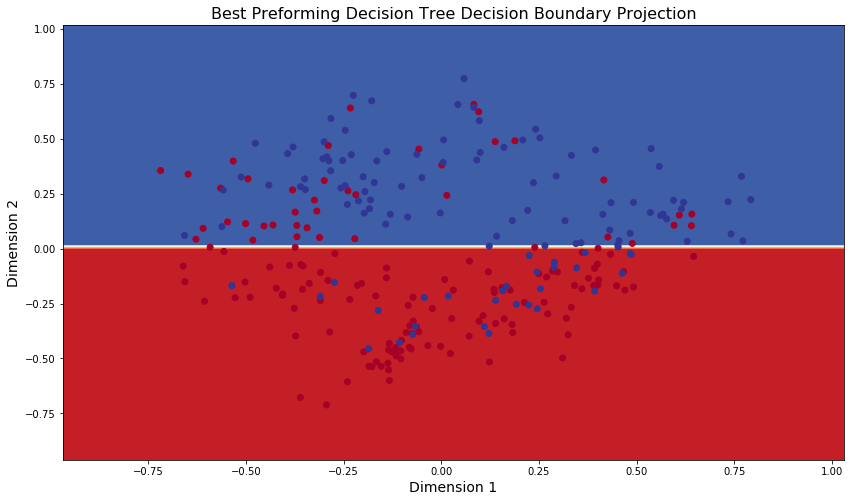

In [62]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Best Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()


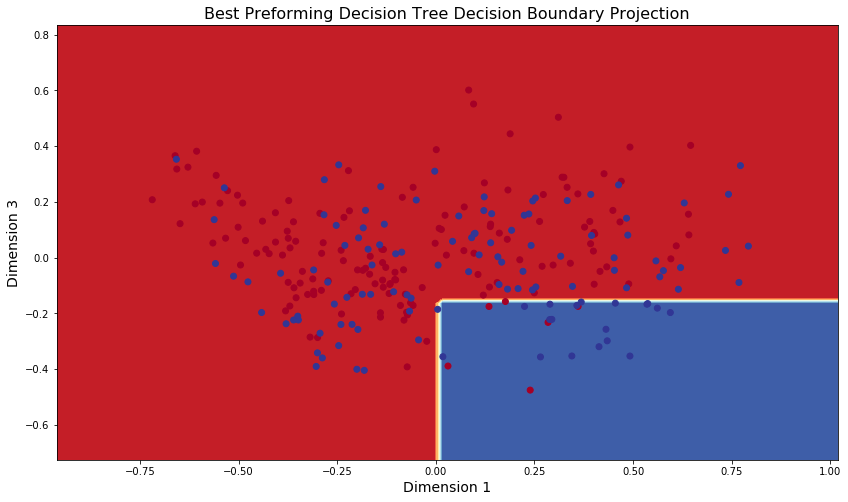

In [63]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()

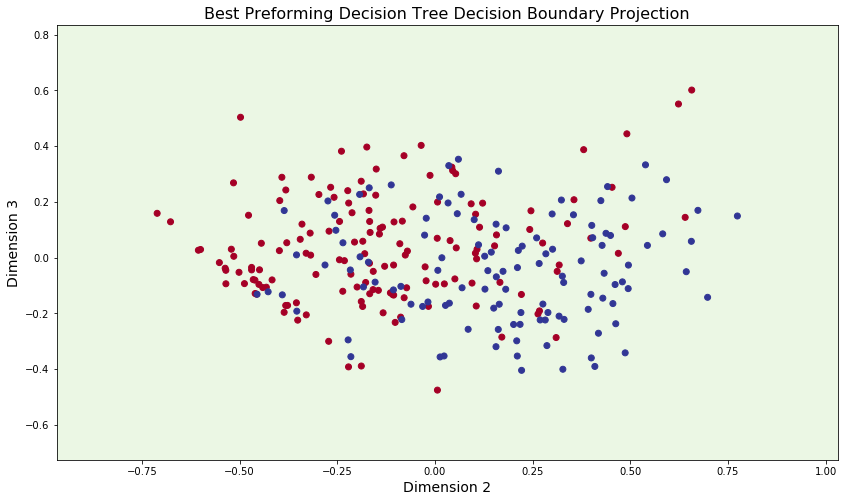

In [64]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[4]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()


Plot worst decision tree decision boundary. Using the same code as above cells but replacing gridObjsDecTree[4] with [2] corresponding to my worst result.

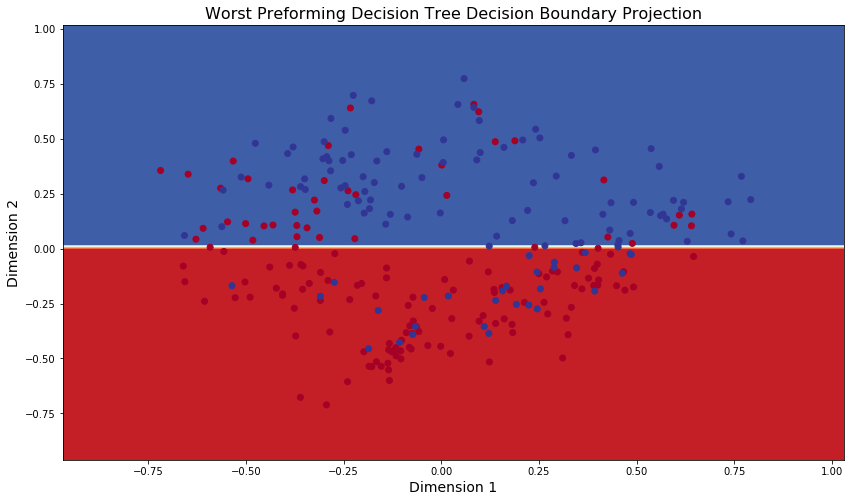

In [76]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Worst Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()

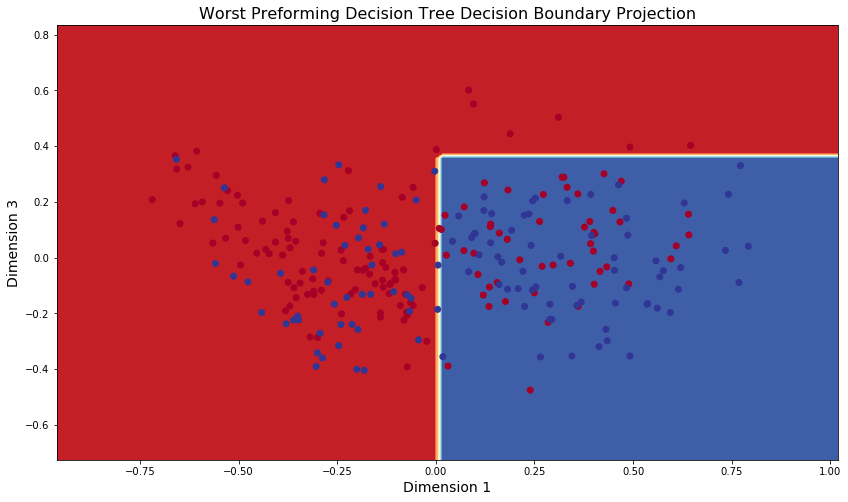

In [77]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()

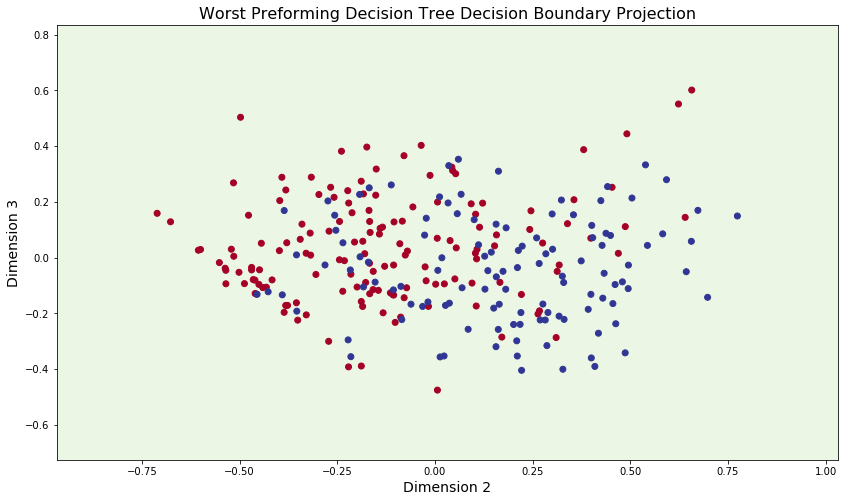

In [78]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[2]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()


## Random Forest Sklearn

Repeating code from above but with best and worst random forest models

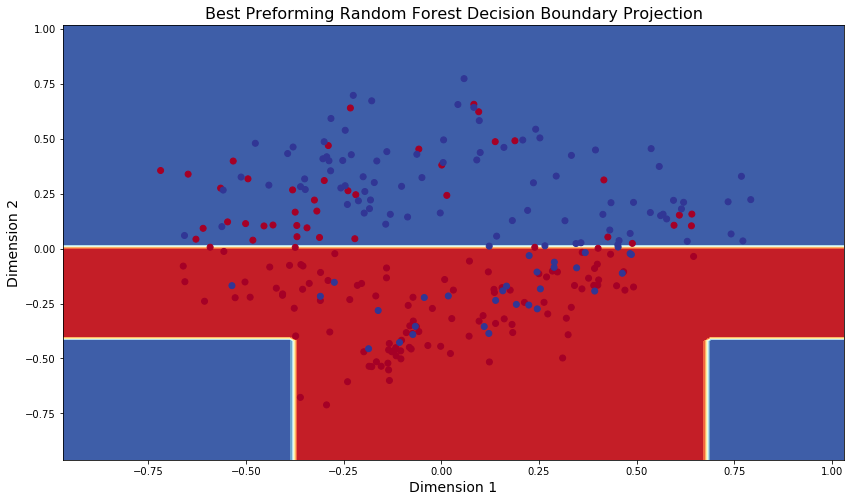

In [66]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Best Preforming Random Forest Decision Boundary Projection", fontsize=16);
plt.show()


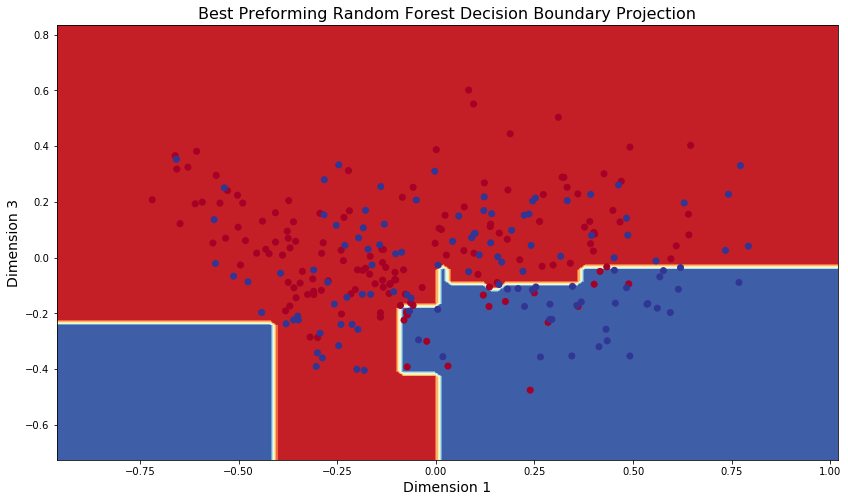

In [67]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()

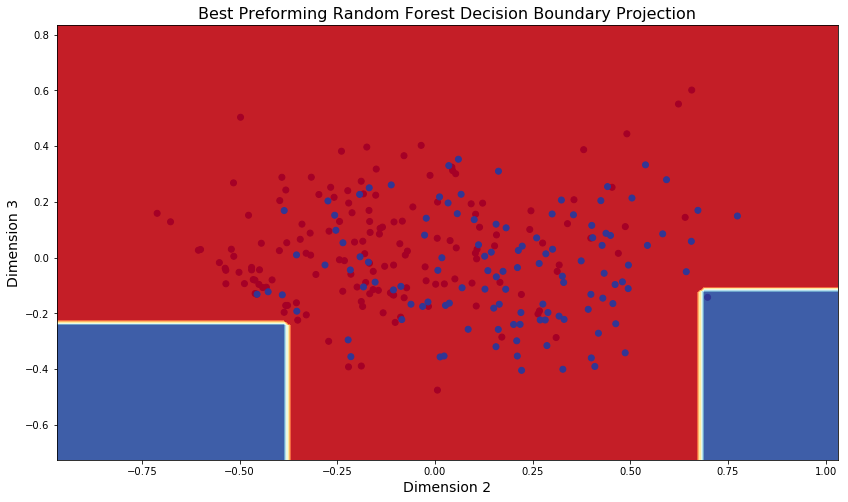

In [69]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[4]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()


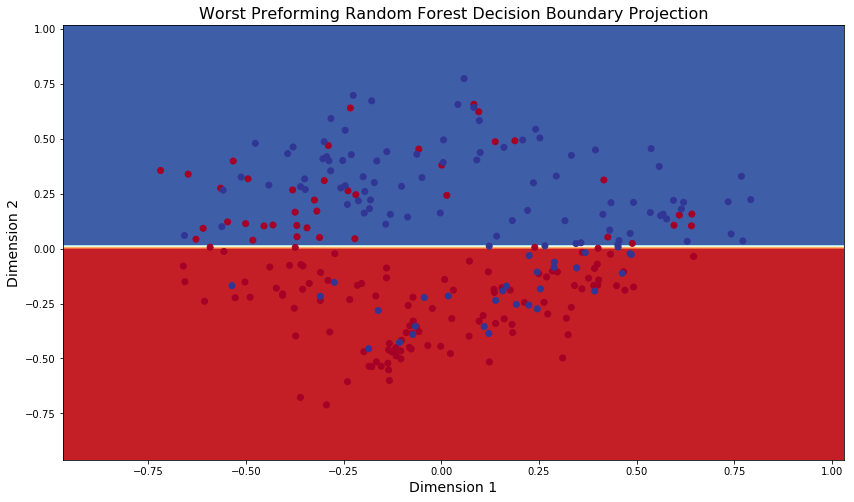

In [79]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Worst Preforming Random Forest Decision Boundary Projection", fontsize=16);
plt.show()

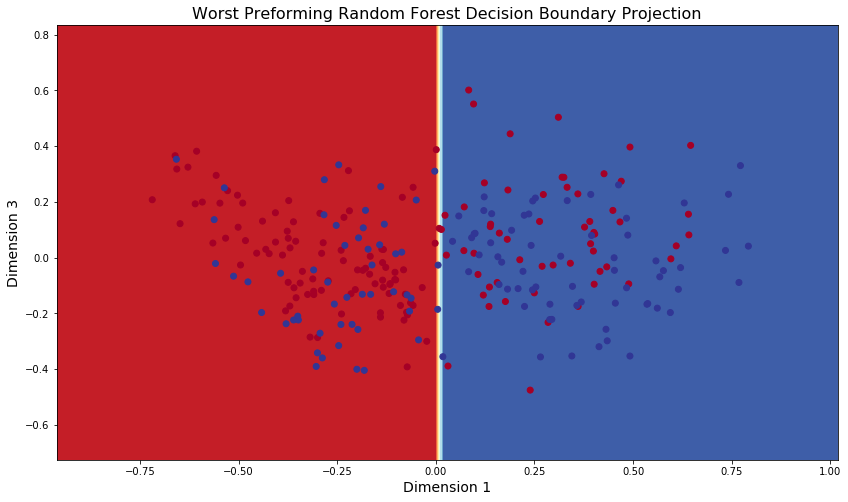

In [80]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()

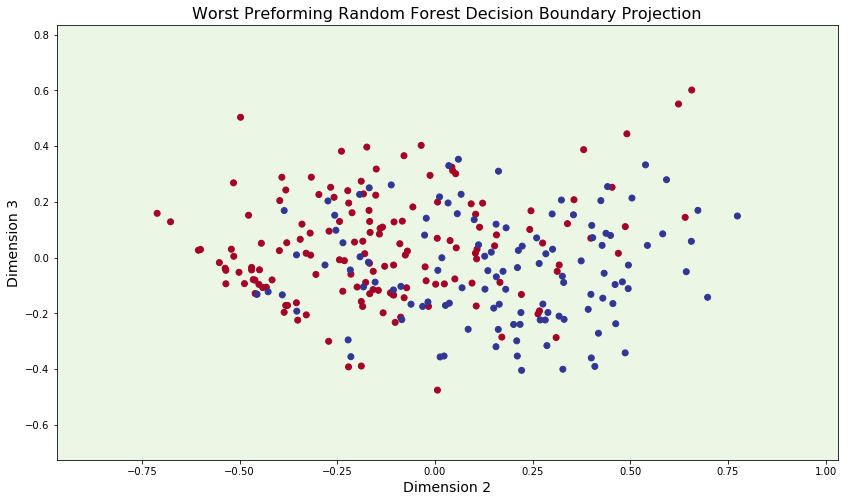

In [81]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[2]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()
